# MACHINE LEARNING POUR LA MODELISATION DU RISQUE DE CREDIT 

## Compréhension de la problématique business

Lorsqu'une banque prête de l'argent a quelqu'un, elle prend le risque que cette dernière ne remborse pas cet argent dans le délais convenu. Ce risque est appelé <b>RISQUE DE CREDIT</b>. Alors avant d'octryer un crédit, les banques verifient si le client(e) qui demande un prêt sera capable de le rembouser. Cette verification se fait grâce à l'analyse de plusieurs parametres tels que: Les revenus, les depenses actuelles du client, etc. Cette analyse est encore effectuée manuellement par plusieurs banques. Ainsi, elle est très consommatrice en temps et en ressources financières.<b>

Grâce au <b>MACINE LEARNING</b>, il est possible d'automatiser cette tâche et de pouvoir prédire avec plus de précision, les clients qui seront en defaut de paiement.<b>

Dans ce projet, nous allons construire un algorythme capable de prédire si une personne est en défaut de paiement ou pas(1 : défaut, 0 : non -défaut). Il s'agit donc d'un problème de classification car nous voulons prédire une variable discrète ( binaire pour être précis). Ensuite nous allons déployer notre algorythme dans une application web

## Importation des librairies et des données

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Model encoding
from sklearn.preprocessing import LabelEncoder

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics.cluster import entropy
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Over sampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.utils import resample

# Model deployement
import joblib


En ce qui concerne les données, il s'agit des informations collctées sur d'anciens clients ayant contracté des prêts qui sont utilisées pour prédire le comportement des nouveaux clients.<b>

Deux (2) types de données peuvent être utilisés pour modéliser la probabilité de défaut de paiement:<b>
* <b>Données liées à la demande de crédit:</b><b>
* <b>Données comportementales decrivant le bénéficiare du prêt.</b><b>

Dans la pratique, les banques utilisent un mélange de ses deux types de données pour construire leur <b>modèl de scoring</b> appliqué a la gestion du risque de crédit.


## Importation des données

In [2]:
df = pd.read_csv(r'https://github.com/JosueAfouda/Credit-Risk-Modeling/raw/master/data_credit.txt', sep =',')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Les données proviennent de **Kaggle** qui est la plus célèbre plateforme de compétitions en Data Science.<b>
    
L'ensemble des données compte 12 variables et 32581 observations (lignes) historiques. Chaque observation correspond à une personne ayant contracté un prêt. On a des variables qui décrivent le prêt (montant, statut, taux d'intérêt, etc.) et d'autres variables qui décrivent la personne ayant ontracté ce prêt (age,
revenu, etc.). Nous allons donc utiliser ces données historiques afin de construire le modèle de scoring qui va prédire le statut des nouveaux candidats à un crédit.<b>
    
Il est très important de comprendre les variables de notre jeu de données :<b>
    
* **person_age**: variable indiquant l'âge de la personne;<b>
* **person income :** variable indiquant le revenu annuel (ou encore le salaire) de la personne :<b>
* **person home ownership :** variable indiquant le statut de la personne par rapport à son lieu d'habitation (popriétaire,   locataire, etc.);<b>
* **person_emp_length :** variable indiquant la durée (en mois) depuis laquelle la personne est en activité professionnelle
* **loan _intent :** variable indiquant le motif du crédit ;<b>
* **loan grade :** Notation de la solvabilité du client. classes de A à G avec A indiquant la classe de solvabilité la plus       élevée et G la plus basse ;<b>
* **loan_amnt :** variable indiquant le montant du prêt ;
* **loan_int_rate :** variable indiquant le taux d'intérêt du crédit ;<b>
* **loan_status :** c'est la variable d'intérêt. Elle indique si la personne est en défaut de paiement (1) ou pas (0):<b>
* **loan percent_income :** variable indiquant le pourcentage du crédit par rapport au revenu (ratio dette / revenu) ;<b>
* **cb_person_default_on_file:** variable indiquant si la personne a été en défaut de paiement ou pas dans le passé
* **cb_person_cred_hist_length** : variable indiquant la durée des antécédents de crédits.<b>
    

Renomons **Encodons** les variables avec des noms plus explicite

In [3]:
df.rename(columns={'person_age': 'age', 
                   'person_income':'salaire_annuelle',
                   'person_home_ownership':'statut',
                   'person_emp_length':'duree_emploi',
                   'loan_intent': 'motif_credit',
                   'loan_grade':'class_solvabilite',
                   'loan_amnt':'montant_pret',
                  'loan_int_rate':'taux_interet',
                  'loan_status':'target',
                  'loan_percent_income':'ratio_dette_revenu',
                  'cb_person_default_on_file':'credit_rembourse',
                  'cb_person_cred_hist_length':'duree_credit_ant'},inplace=True)
df.head()

,age,salaire_annuelle,statut,duree_emploi,motif_credit,class_solvabilite,montant_pret,taux_interet,target,ratio_dette_revenu,credit_rembourse,duree_credit_ant
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


**Passons à présent à l'analyse exploratoire des données qui nous permettra de mieux les comprendre.**

# Analyse exploratoire

In [4]:
# Structure de la DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 32581 non-null  int64  
 1   salaire_annuelle    32581 non-null  int64  
 2   statut              32581 non-null  object 
 3   duree_emploi        31686 non-null  float64
 4   motif_credit        32581 non-null  object 
 5   class_solvabilite   32581 non-null  object 
 6   montant_pret        32581 non-null  int64  
 7   taux_interet        29465 non-null  float64
 8   target              32581 non-null  int64  
 9   ratio_dette_revenu  32581 non-null  float64
 10  credit_rembourse    32581 non-null  object 
 11  duree_credit_ant    32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
# Voir s'il y'a des valeurs manquantes
df.isnull().sum().sort_values(ascending=False)

taux_interet          3116
duree_emploi           895
age                      0
salaire_annuelle         0
statut                   0
motif_credit             0
class_solvabilite        0
montant_pret             0
target                   0
ratio_dette_revenu       0
credit_rembourse         0
duree_credit_ant         0
dtype: int64

In [6]:
# Résumé statistique
df.describe()

,age,salaire_annuelle,duree_emploi,montant_pret,taux_interet,target,ratio_dette_revenu,duree_credit_ant
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [7]:
df.describe(include="O")

,statut,motif_credit,class_solvabilite,credit_rembourse
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


* Nous remarquons que les moyennes et les écart-types sont très différents d'une variable à une autre. Cela indique que les données ne sont pas à la même échelle, Il faudra probablement normaliser les données avant de les modéliser, en effet, certains algoritmes de Machine Learning nécessitent une normalisation des données pour un meilleur résultat. C'est le cas par exemple de la Regression Logistique<b>
* De plus, il y a des valeurs manquantes au niveau des variables duree_emploi et taux_interet... Certains variables comme âge, dure_emploi.. contiennent probablement des valeurs aberantes vu la différence très importante entre leur 3è quartile et leur maximum. Les valeurs aberantes sont très distantes des autres valeurs et ne sont donc pas représentatives de l'ensemble des données. Elles peuvent causer d'importatantes erreurs de modélisation.<b>
    
Dans la partie consacrée au nettoyage des données, nous aurons principalement à trater les valeurs aberrantes (outlers) et les valeurs manquantes.

**Analyse de la variable cible (target)**

In [8]:
# Table de frequence de la variable cible

Target = (df['target'].value_counts()/len(df))*100
Target


0    78.183604
1    21.816396
Name: target, dtype: float64

[Text(0.5, 1.0, 'statut du crédit')]

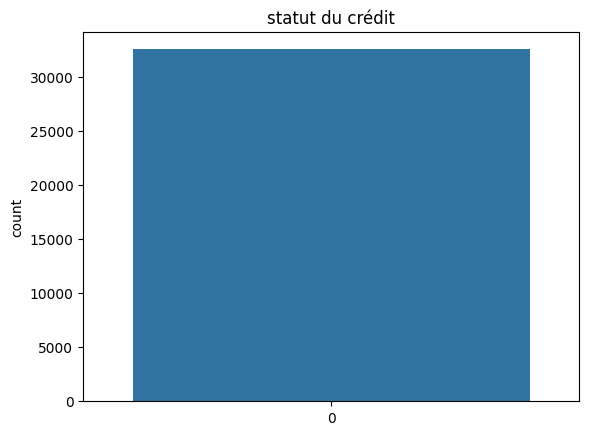

In [9]:
# Diagramme a barre de la variable cible 

sns.countplot(df['target']).set(title="statut du crédit")

On remarque ici un deséquilibre au niveau des deux classe. En effet, la classe **0 = non-défaut de paiement**  represente 78,18% et la classe **1= défaut de paiement** represente 21,82%. Ses chiffre se reflete dans le graphique. Cela pourrait provoquer des biais dans notre modélisation. Nous essayeront de pallier à ce probleme dans la suite de notre projet.

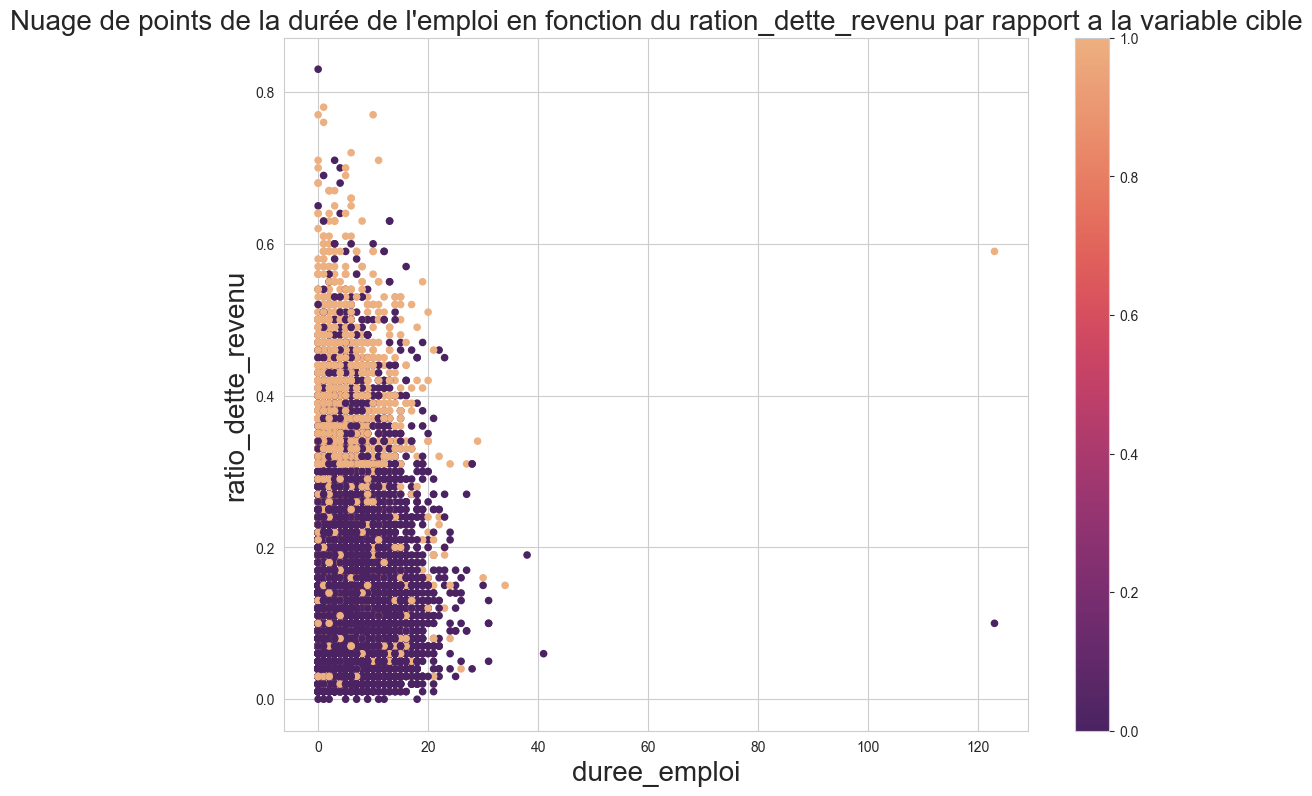

In [10]:
#  Nuage de point entre la durée d'activité professionnelle et le ratio_dette_revenu avec des point violet pour 
#       les clients ayant fait défaut et rose pour les clients n'ayant pas fait défaut 


plt.rcParams["figure.figsize"] = (12, 9)
sns.set_style("whitegrid")
plt.scatter(df['duree_emploi'],df['ratio_dette_revenu'], c=df['target'], cmap="flare_r", s=20)
plt.title("Nuage de points de la durée de l'emploi en fonction du ration_dette_revenu par rapport a la variable cible", size=20) 
plt.xlabel("duree_emploi", size=20)
plt.ylabel("ratio_dette_revenu", size=20)
plt.colorbar()

Ces résultats montrent qu'il y un déséquilibre de classe très importants dans les données. En effet, seulement environ 22% de clients sont en défaut de paiement contre un peu plus de 78% de bons clients.<b>
    
Le déséquilibre de classe est souvent observé dans les données de crédit. la majorité des demandeurs de crédit sont incités à ne pas être en défaut de paiement car plus ils remboursent le crédit dans les délais, plus leurs côtes de crédit augmentent et donc ils peuvent à nouveau emprunter pour effectuer d'autres investissements.<b>
    
Si le déséquilibre observé ici est tout à fait normal, il n'en demeure moins que cela représente un grand défi de classification pour les algorithmes de Machine Learning<b>
    
Dans la partie préparation des données pour la modélisation, il va falloir résoudre ce problème.

[Text(0.5, 1.0, "Boite a moustache du 'ratio_dette_revenu' en fonction de 'target'")]

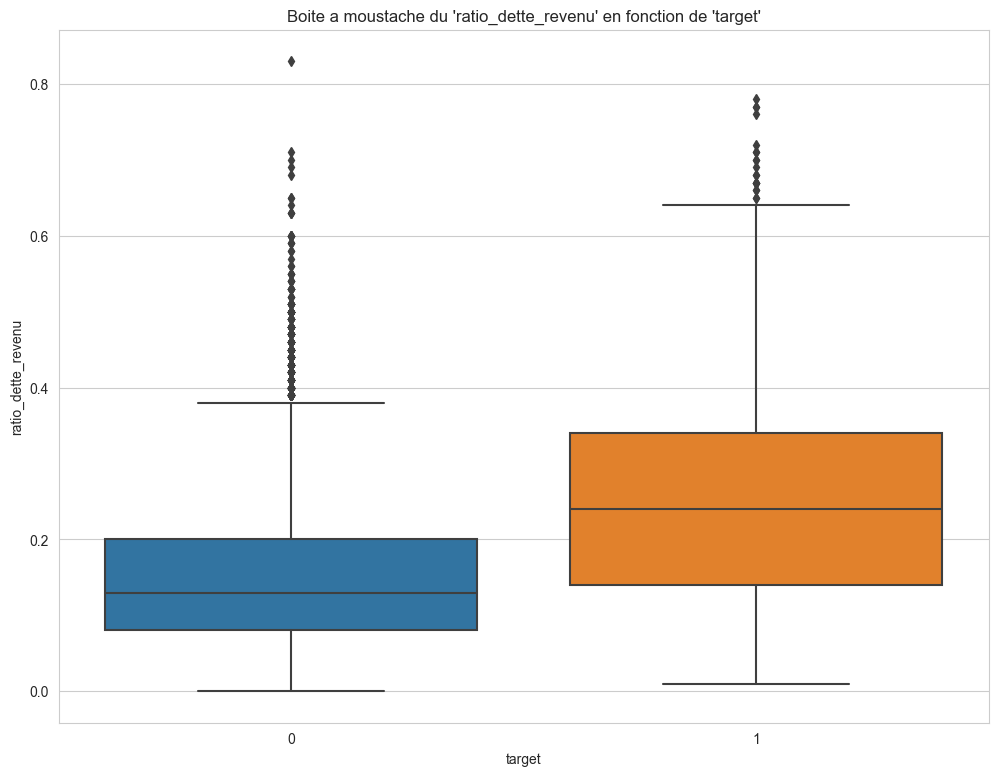

In [11]:
# 'ratio_dette_revenu' vs 'target'

sns.boxplot(x=df['target'] ,y= df['ratio_dette_revenu']).set(title="Boite a moustache du 'ratio_dette_revenu' en fonction de 'target'")

Selon ce garphique, le ratio moyen dette_revenu est plus élevé chez les clients en défaut de paiement que chez les bons clients. En effet, lorsque le ratio_dette_revenu est très élévé, cela veut dire tout simplement que le crédit est trop élevé par rapport aux revenus de la personne. Et lorsqu'une personne a un crédit trop élevé par rapport à ses revenus, le risque qu'elle soit en défaut de paiement est logiquement et naturellement important.

In [12]:
# Fonction de construction d'un graphique montrant la rélation entre une variable indépendante et la variable cible

def show_relation (df, feature, title_y):
    sns.boxplot(x=df['target'] ,y= feature).set(title=title_y)
    

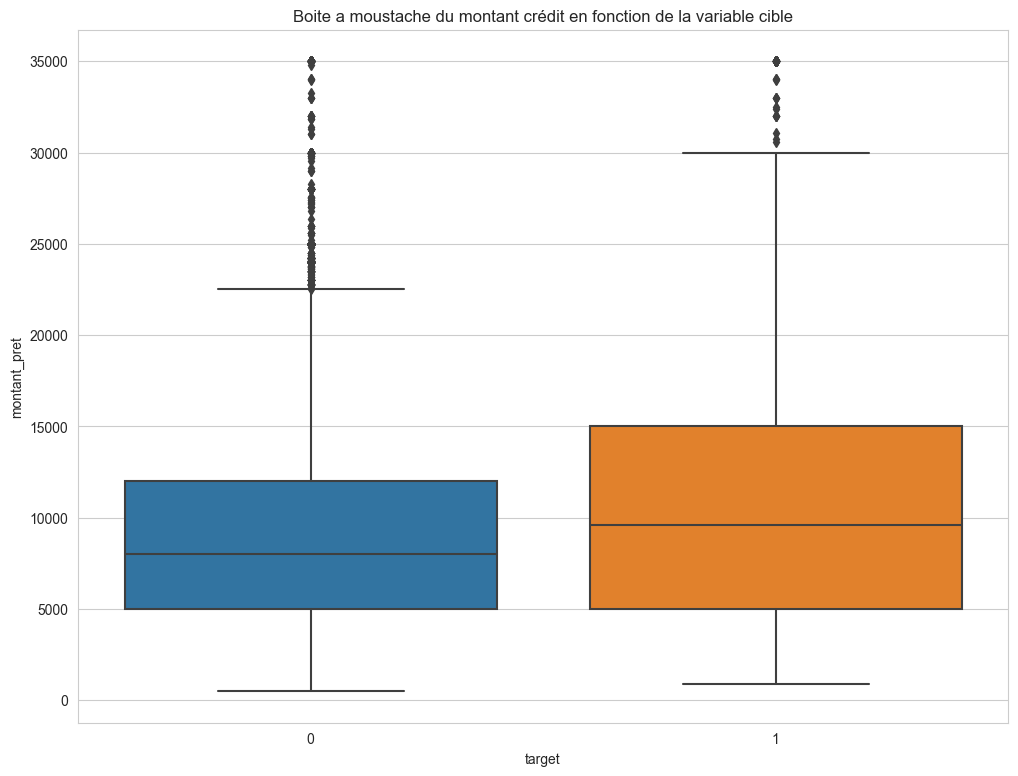

In [13]:
# Relation entre le montant du crédit et la variable cible

show_relation (df, df['montant_pret'], 'Boite a moustache du montant crédit en fonction de la variable cible')

Les  personnes qui ont un défaut de paiement ont en moyenne un montant de crédit plus élévé que les autres comme le montre le graphique

Text(0, 0.5, 'Frequency')

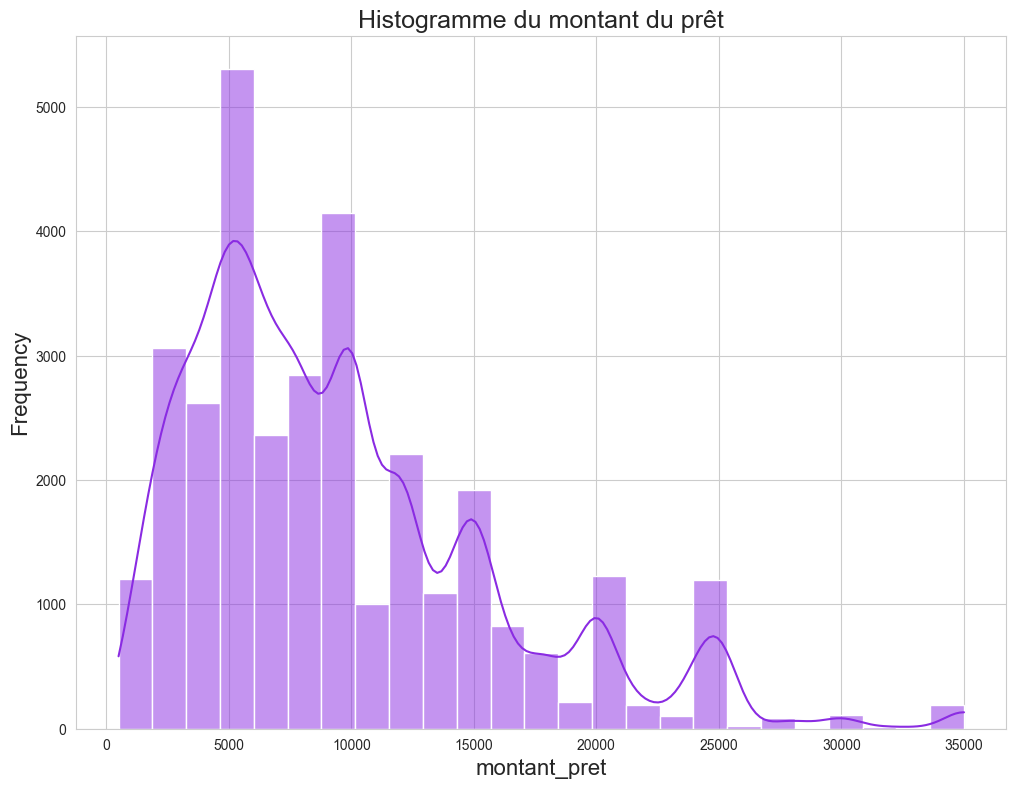

In [14]:
# Histogramme du montant du crédit

sns.histplot(df['montant_pret'],kde=True, color="blueviolet", bins=25)
plt.title("Histogramme du montant du prêt", fontsize=18)
plt.xlabel('montant_pret', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

D'après le graphique ci-dessus, la distribution de la variable indiquant le montant du crédit est asymétrique positive (étalée vers la droite) donc ne suit probablement pas une loi normale.<b>
    
Plusiers algorithmes de Machine Learning sont conçus pour fonctionner avec des données gaussiennes. Donc, pour ne pas avoir des résultats biaisés, il est indispensable de vérifier l'asymétrie de chaque variable quantitative et d'effectuer si besoin une transformation de variable avant la phase de modélisation.<b>
<b>
    
    
Il est intéressant de visualiser la distribution de la variable indiquant le montant du crédit chez les personnes en défaut de paiement et chez les autres afin de pouvoir effectuer une comparaison.

In [15]:
c = df.groupby(['montant_pret','target']).size()

<AxesSubplot: xlabel='montant_pret', ylabel='Count'>

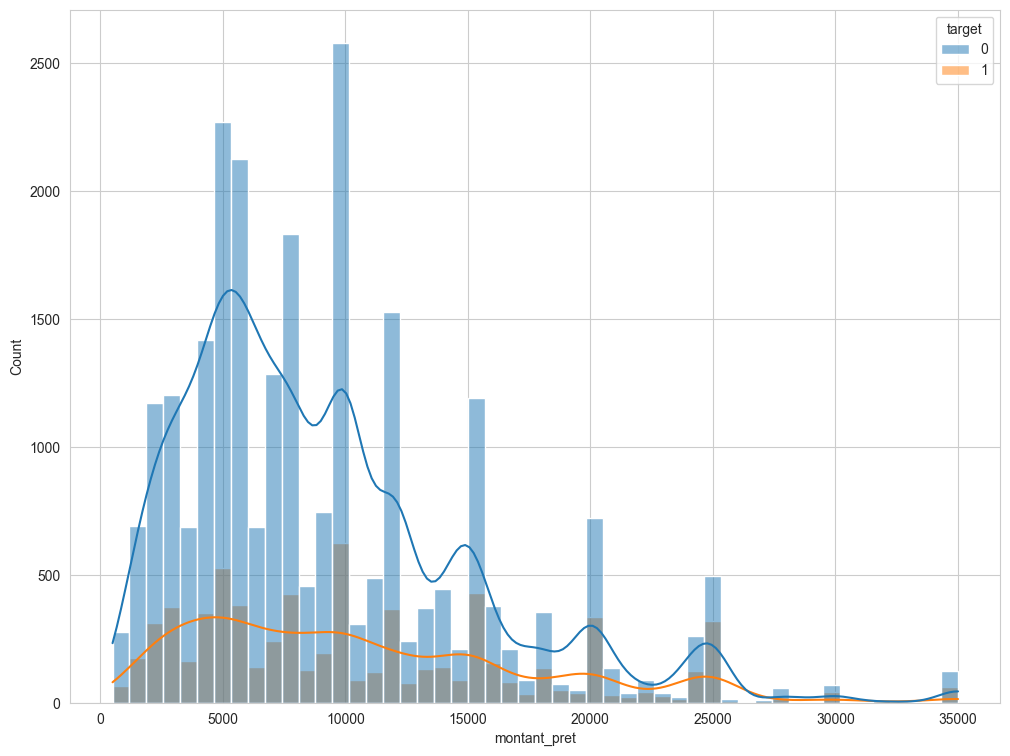

In [16]:
# Histogramme du montant de la dette par rapport a la variable cible
sns.histplot(data =df ,x = 'montant_pret',  alpha = .5, hue = 'target', bins=50, kde=True)


Les deux histogrammes semblent être identiques mais en observant très bien on constate par exemple que les barres au niveau des montants très élevés sont plus longues chez les personnes en défaut de paiement que chez les autres. Cela veut dire qu'il y a beaucoup plus de personnes en défaut de paiement qui ont emprunté de grosses somme d'argent en comparaison aux personnes qui ne sont pas en défaut de paiement.<b>


### Le salaire annuel influence t'il le remboursement du crédit ?

Analysons à présent la variable indiquant le revenu annuel ainsi que sa relation avec la variable cible

Text(0, 0.5, 'Frequency')

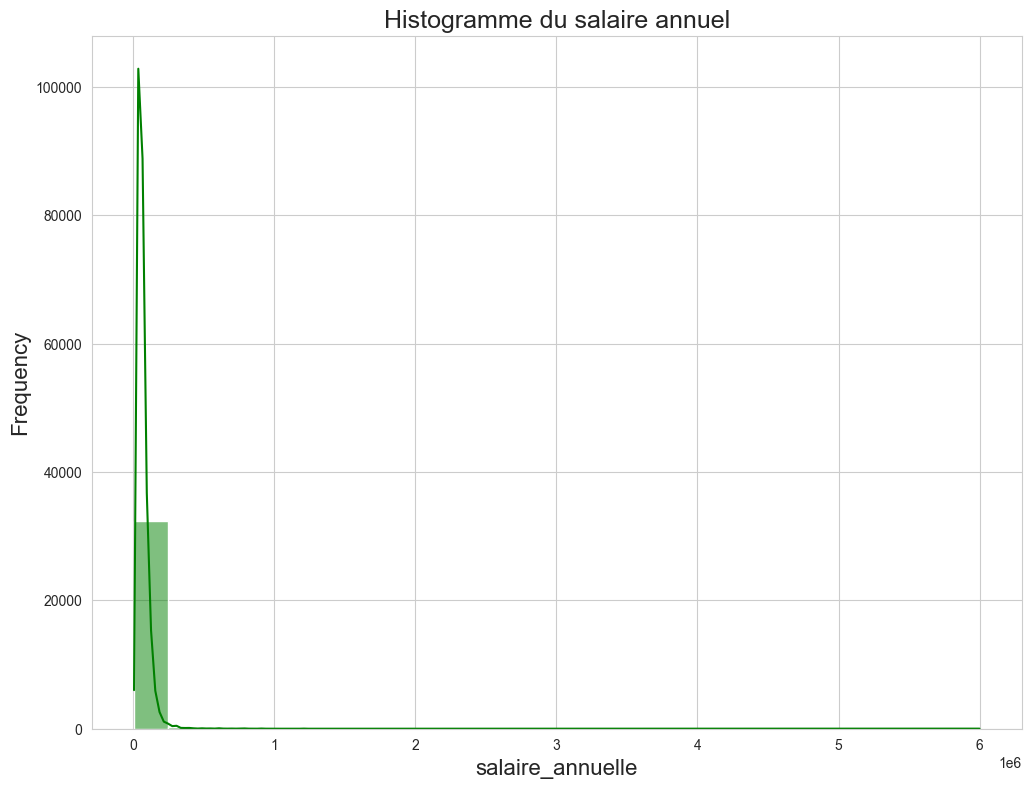

In [17]:
# Histogramme des revenus annuelles

sns.histplot(df['salaire_annuelle'],kde=True, color="green", bins=25)
plt.title("Histogramme du salaire annuel", fontsize=18)
plt.xlabel('salaire_annuelle', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

L'histogramme des revenus annuels a une seule grande barre ce qui montre qu'il y a une certaine anomalie au niveau des valeurs de cette variable. En effet, le résumé statistique de la variable salaire_annuelle ainsi que son histogramme révèlent la présence de valeurs aberrantes (outliers) au niveau de cette
variable. Nous pouvons aussi voir ces ouliers en traçant un nuage de points

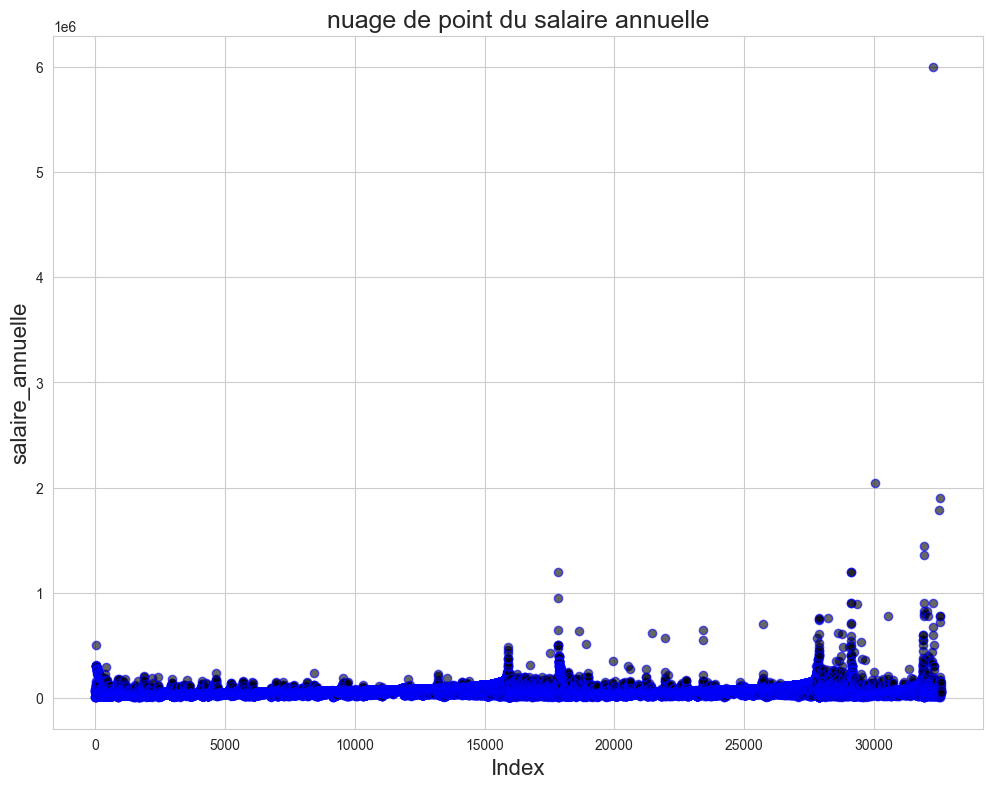

In [18]:
# Nuage de points de la variable salaire_annuelle


plt.scatter(df.index, df['salaire_annuelle'], color='black', marker="o", edgecolor='blue', linewidth=1, alpha = .6)
plt.title("nuage de point du salaire annuelle", fontsize=18)
plt.xlabel('Index', fontsize=16)
plt.ylabel('salaire_annuelle', fontsize=16)
plt.show()

Le nuage de points ci-dessus confirme bel et bien la presence de valleur aberrantes au niveau de la variable indiquant le revenu annuel. Il y'a un salaire annuel enorme de 6 million de dollars, alors que tous les autre salaire ne depasse pas environs 2 million de dollars

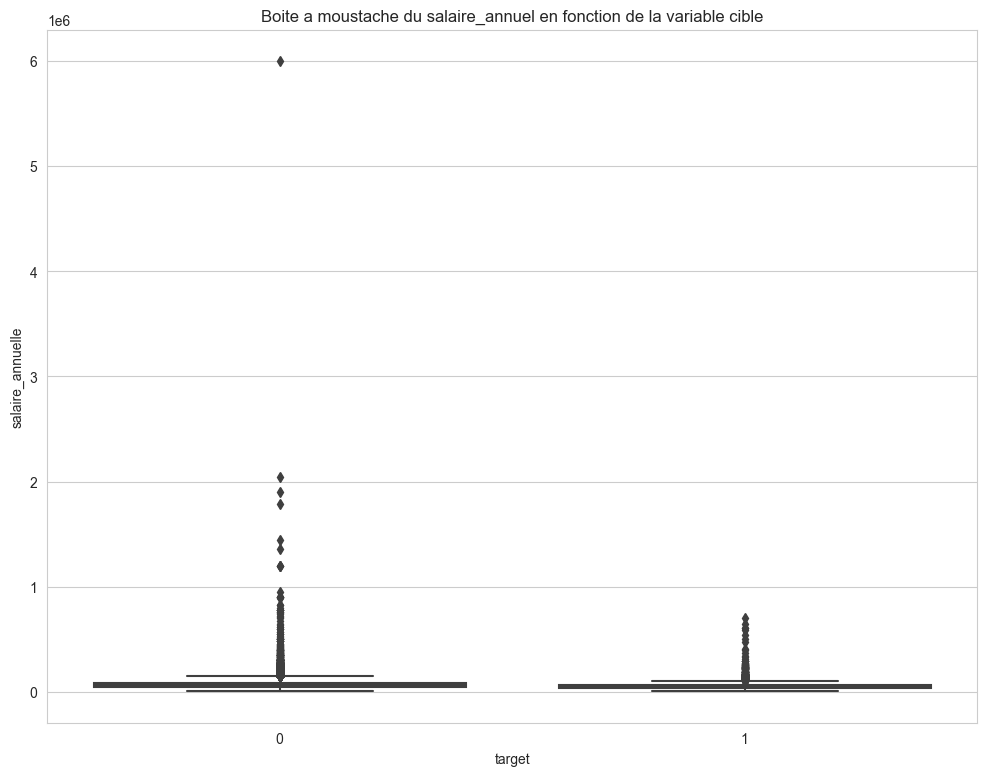

In [19]:
# boite à moustache Salaire_annuel vs variable cible

show_relation( df, df['salaire_annuelle'], 'Boite a moustache du salaire_annuel en fonction de la variable cible')

En observant les boites à moustache du salaire annuel en fonction du revenu, on voit qu'ils sont très applati. Ce qui temoigne d'une anomali **presence de valeurs aberrantes**. Cette hypotheses rejoint les anomalies detecter lors de l'histogramme et du nuage de point du salaire annuel.<b>
<b>
    
Pour palier a ce probleme et mieux visualiser nos boite, nous allons créer un sous echantillons contenant uniquement les salaire qui sont inferieurs a 100 000 dollars l'année. Nous avons choisi 100 000 dollars car, le tableau statistique réaliser plus haut, nous montre que le troisième quantile du salaire annuel est d'environ 75 0000 dollars et son maximum, d'environ 6 millions de dollars. Nous supposons donc que la majorité des observations du salaire annuel sont inferieur a 100 000 dollars

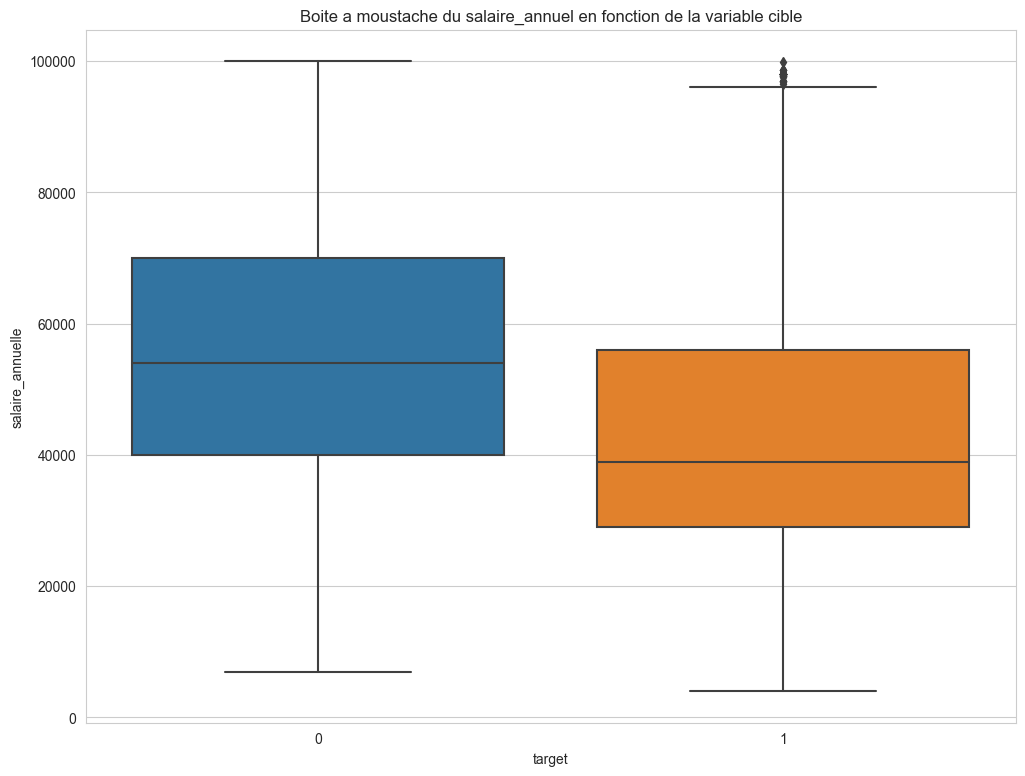

In [20]:
# boite à moustache Salaire_annuel vs variable cible

Sc = df[df['salaire_annuelle']<100000]
show_relation( Sc, Sc['salaire_annuelle'], 'Boite a moustache du salaire_annuel en fonction de la variable cible')

On peut voir à travers ces boites à moustache que les personnes qui ont été en défaut de paiement, ont en moyenne un salaire annuel inferieur à celui des bon clients. Cette information renforce notre connaissance acquise précedemment quant au profil des personnes en défaut de paiement.<b>
 

### Le taux d'intérêt influence t'il le remboursement du crédit ?

Avant de tracer un graphique montrant la rélation entre le taux d'intérêt et la variable cible, visualisont d'abors l'histogramme de la variable indiquant le taux d'intérêt.

Text(0, 0.5, 'Frequency')

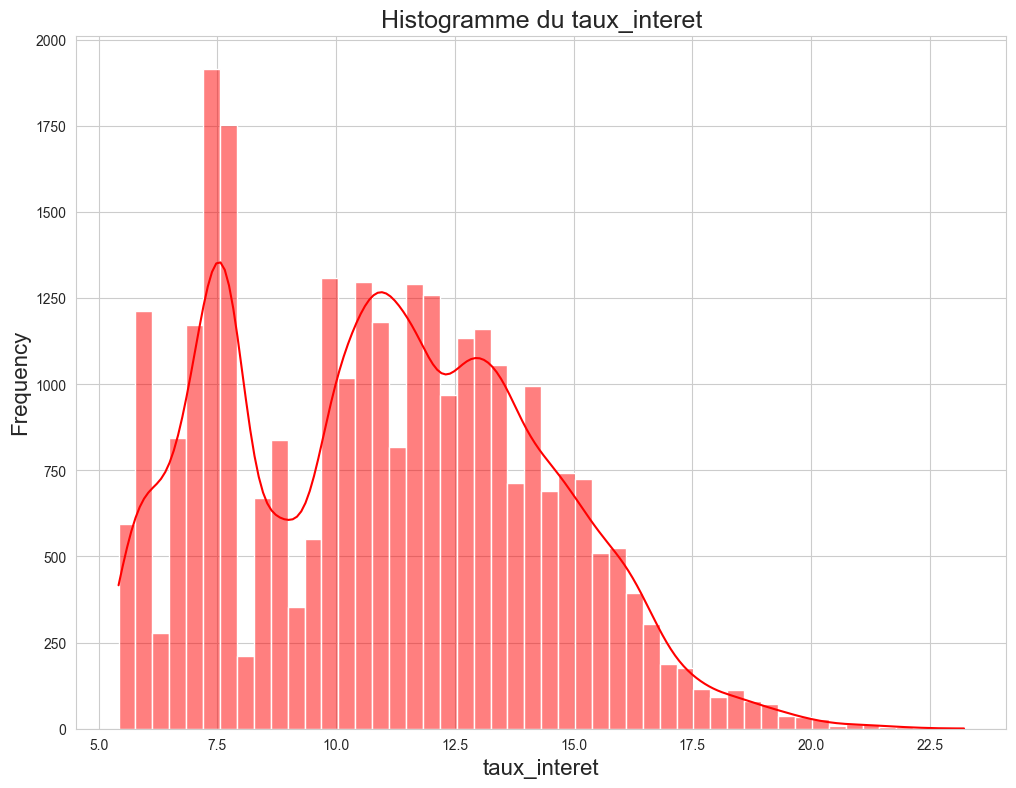

In [21]:
# Histogramme du taux d'intérêt

sns.histplot(df['taux_interet'],kde=True, color="red", bins=50)
plt.title("Histogramme du taux_interet", fontsize=18)
plt.xlabel('taux_interet', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Tous les crédit ont un taux d'intérêt superieur à 5% et tres peux ont un taux superieur a 20%

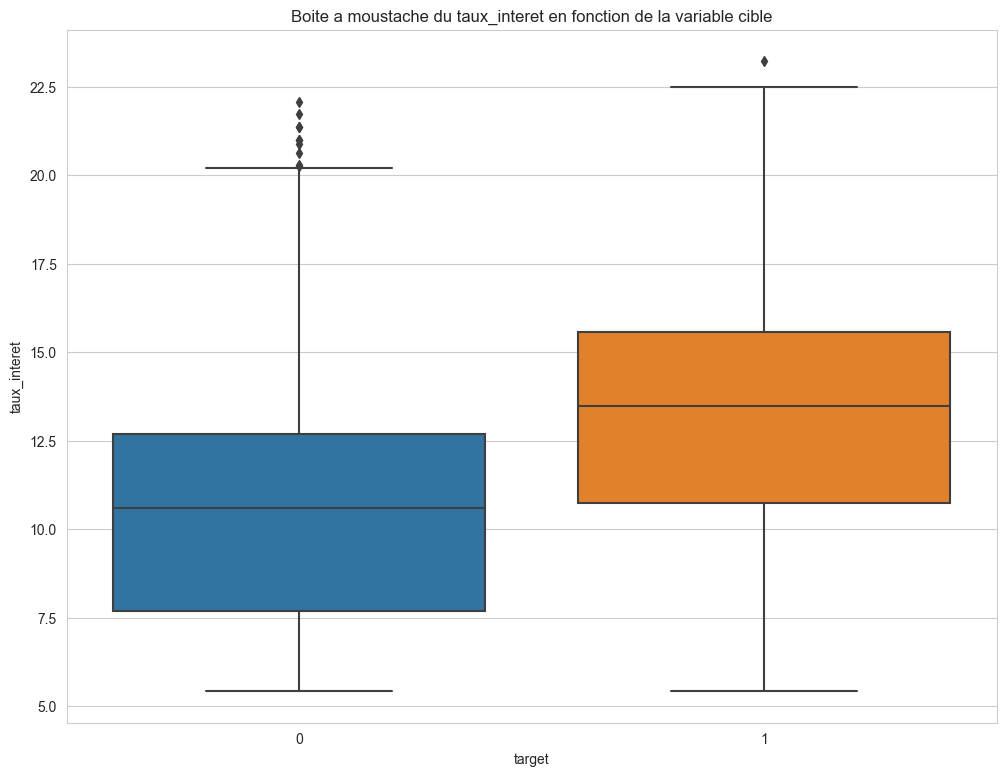

In [22]:
# Taux d'interêt vs Variable cible

show_relation( df, df['taux_interet'], 'Boite a moustache du taux_interet en fonction de la variable cible')

Les personnes en défaut de paiement ont en moyenne un taux d'intérêt plus élevé que les personnes qui ne sont pas en défaut de paiement. Ce résultat vient confirmer les résultats précédents sur le comportement des personnes en défaut de paiement. En effet, nous avons vu que ces personnes empruntent beaucoup plus de grosses sommes que les autres, ils ont donc des crédits a forts taux d'intéret.<b>
    

### Le temps pendant le quel une personne est resté en activité professionnelle, à t'il un impact sur le remborsement du crédit ?

Le temps pendant lequel une personne est restée en activité professionnelle peut probablement conditionner le remboursement ou non de son crédit. Construisons un histogramme de la variable duree_emploi.

Text(0, 0.5, 'Frequency')

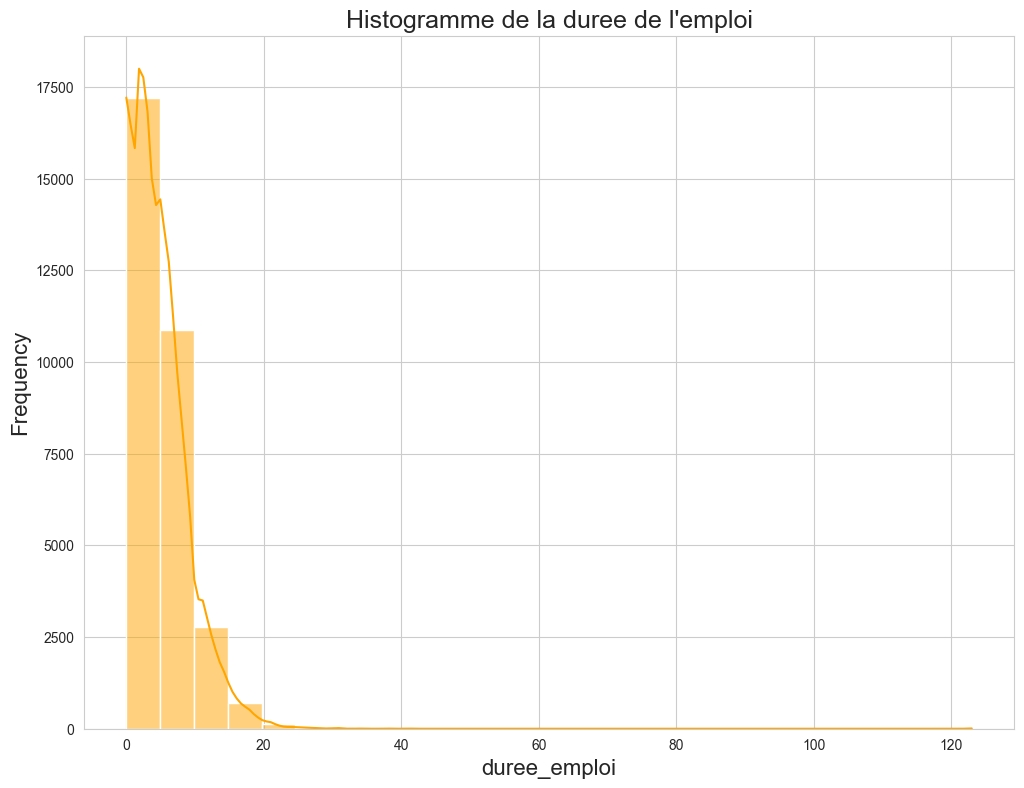

In [23]:
# Histogramme de la variable durée emploi

sns.histplot(df['duree_emploi'],kde=True, color="orange", bins=25)
plt.title("Histogramme de la duree de l'emploi", fontsize=18)
plt.xlabel('duree_emploi', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

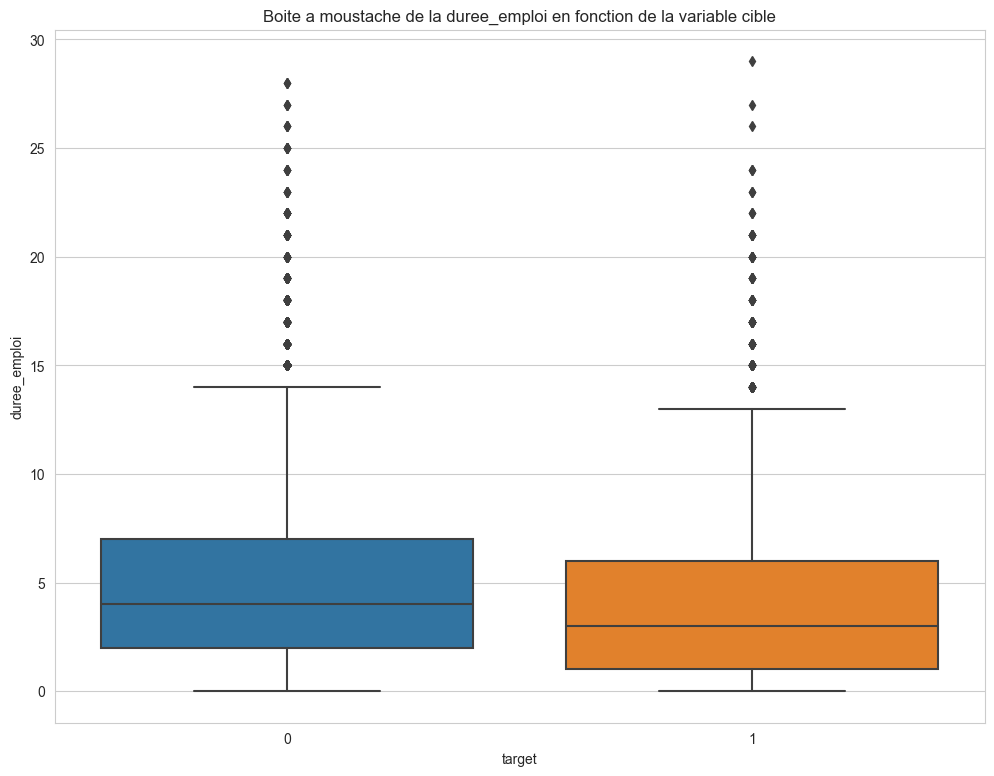

In [24]:
# duree_emploi VS variable cible

Sc = df[df['duree_emploi']<30]
show_relation( Sc, Sc['duree_emploi'], 'Boite a moustache de la duree_emploi en fonction de la variable cible')

Il apparait que les personnes en défaut de paiement ont en moyenne une durée d'activité professionnelle inférieur à celle des autres.

### L'âge a t'elle une influence sur la capacité à rembourser une dette ?

Text(0, 0.5, 'Frequency')

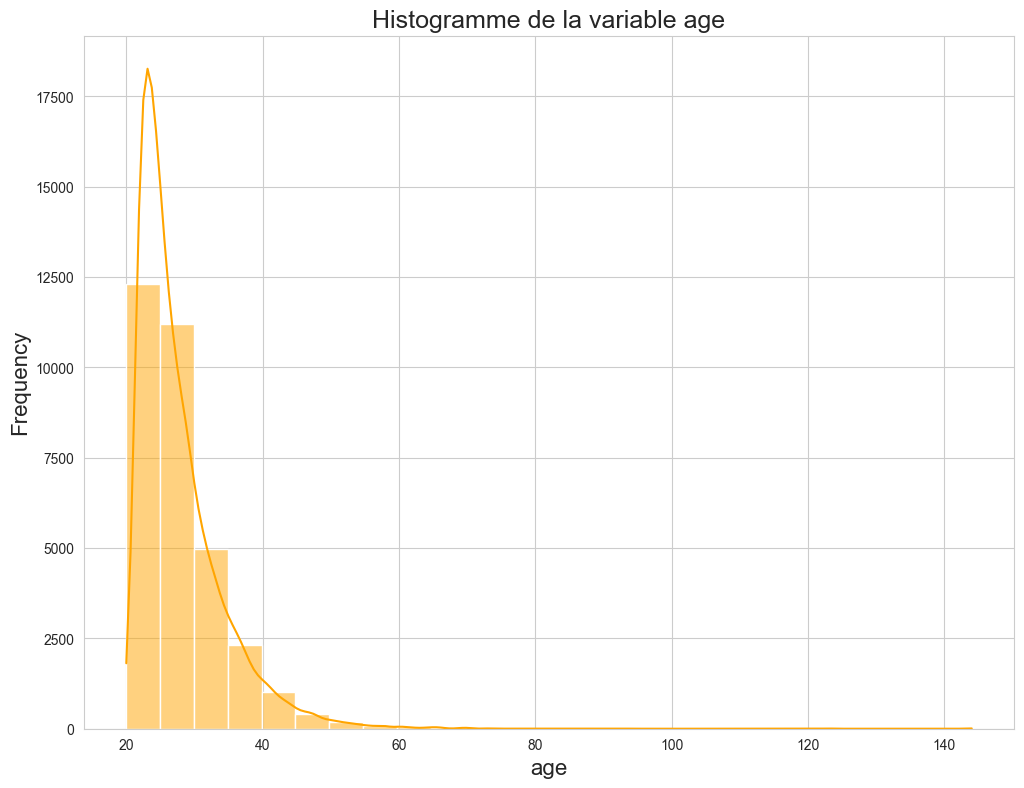

In [25]:
# Histogramme de la variable age

sns.histplot(df['age'],kde=True, color="orange", bins=25)
plt.title("Histogramme de la variable age", fontsize=18)
plt.xlabel('age', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

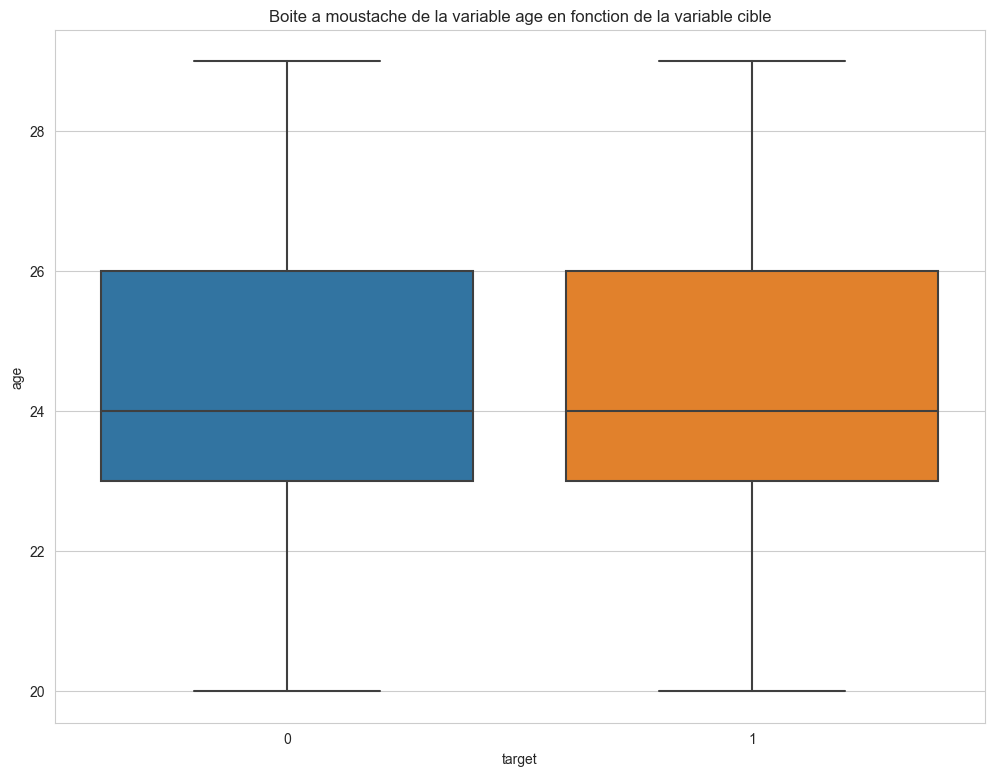

In [26]:
# Variable âge VS variable cible

Sc = df[df['age']<30]
show_relation( Sc, Sc['age'], 'Boite a moustache de la variable age en fonction de la variable cible')

On remarque que l'âge n'a aucune influence sur la capacité à rembourser un crédit

### Le statut de la personne par rapport a son lieu d'habitation (propriétaire, locataire..) à t'il une influence sur sa capacité à rembourser un crédit ?

<AxesSubplot: xlabel='statut', ylabel='count'>

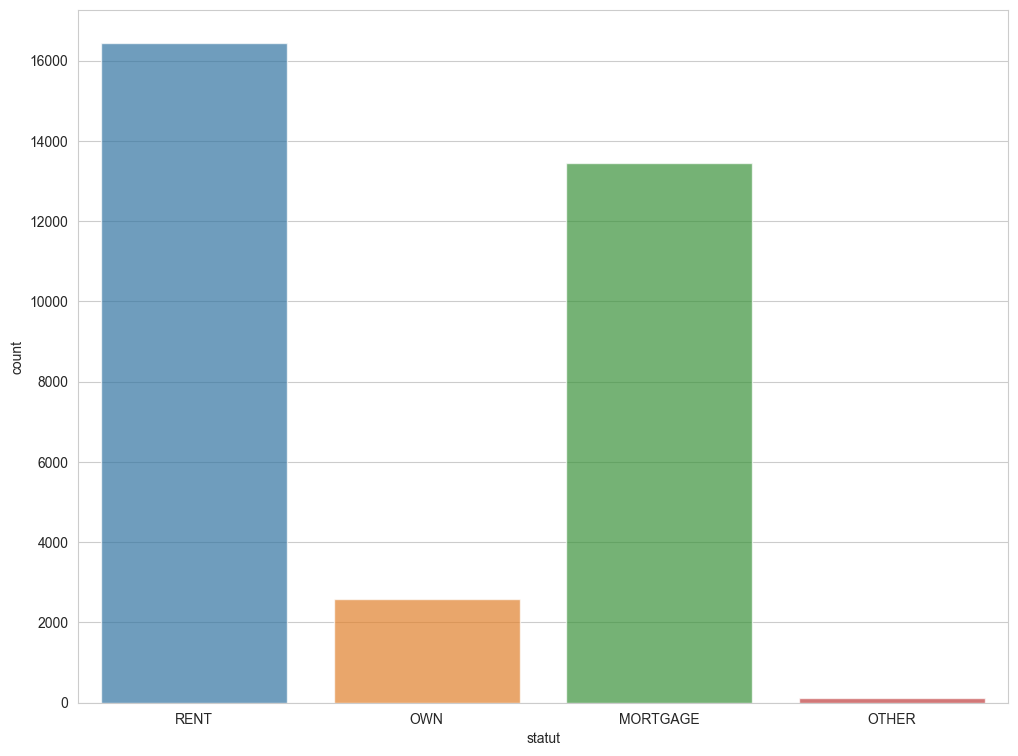

In [27]:
# Variable statut de la personne

sns.countplot(x=df['statut'], alpha = 0.7)


RENT (Personne en location), OWN (Propriétaire), MOTGAGE (personnes ayant hypothequer leur maison), OTHER (autre) 

In [28]:
# Statistique de la variable statut en fonction de la variable cible

df.groupby(['statut','target']).size()

statut    target
MORTGAGE  0         11754
          1          1690
OTHER     0            74
          1            33
OWN       0          2391
          1           193
RENT      0         11254
          1          5192
dtype: int64

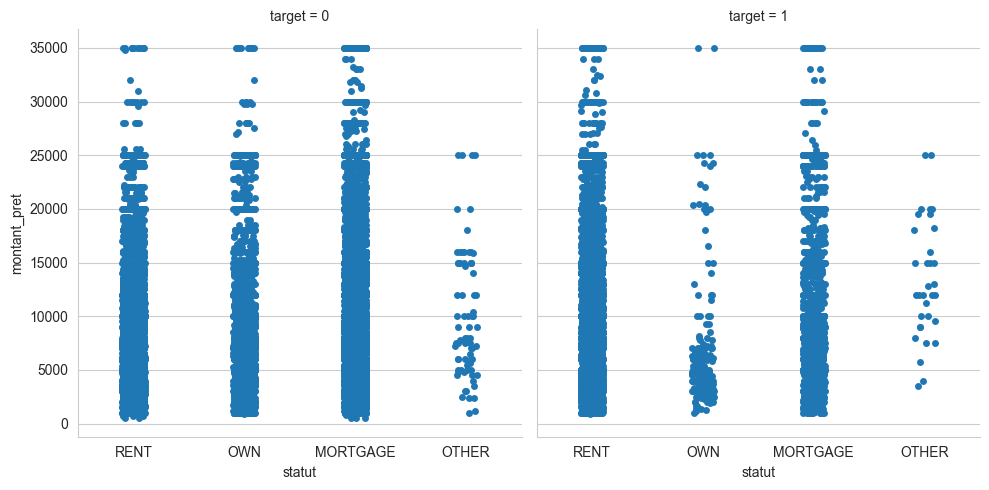

In [29]:
# variable statut VS variable cible

sns.catplot(data=df, x='statut',y = 'montant_pret', col='target')


En observant ces deux précedent resultats, on remarque que le statut de l'individu n'influence pas la capacité de remboursement de la dette.<b>
    
Pour finir cette analyse exploratoire, analysons les motifs pour lesquels les personnes emprunts de l'argent

### Le motif d'emprunt à t'il une influence sur la capacité de rembourser un emprunt ?

<AxesSubplot: xlabel='motif_credit', ylabel='count'>

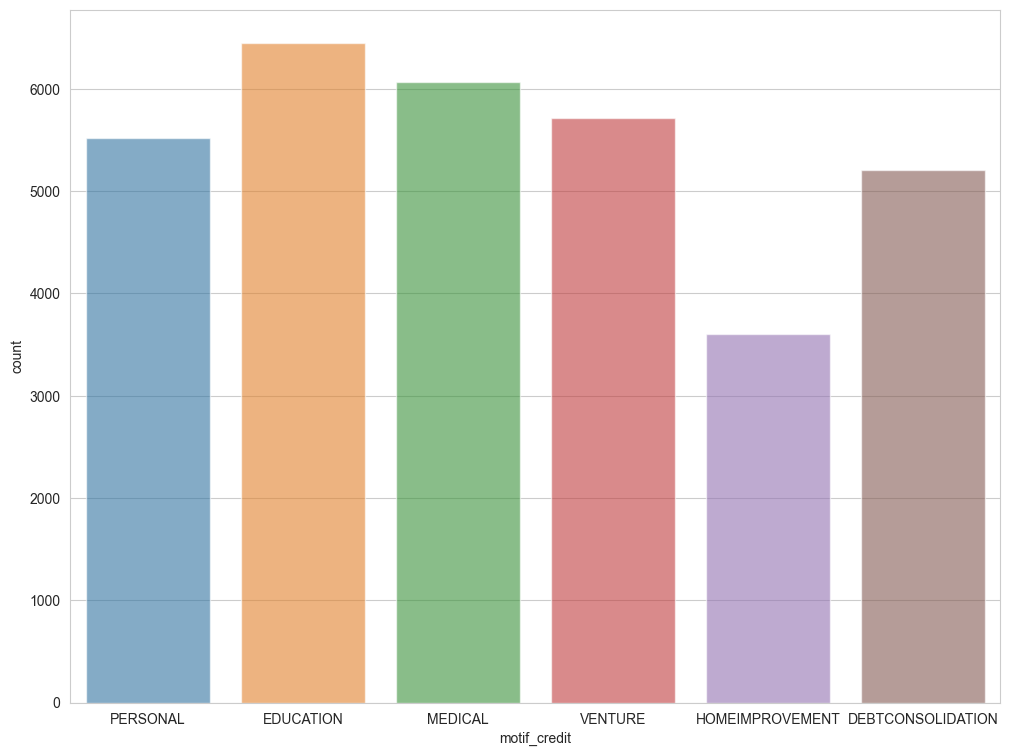

In [30]:
# Motif de l'emprunt

sns.countplot(x=df['motif_credit'], alpha = .6)

In [31]:
# Statistique du motif de l'emprunt par rapport à la variable cible

(df.groupby(['motif_credit','target']).size())*100/len(df)

motif_credit       target
DEBTCONSOLIDATION  0         11.423836
                   1          4.573218
EDUCATION          0         16.396059
                   1          3.409963
HOMEIMPROVEMENT    0          8.176545
                   1          2.888186
MEDICAL            0         13.658267
                   1          4.975292
PERSONAL           0         13.575397
                   1          3.370062
VENTURE            0         14.953501
                   1          2.599675
dtype: float64

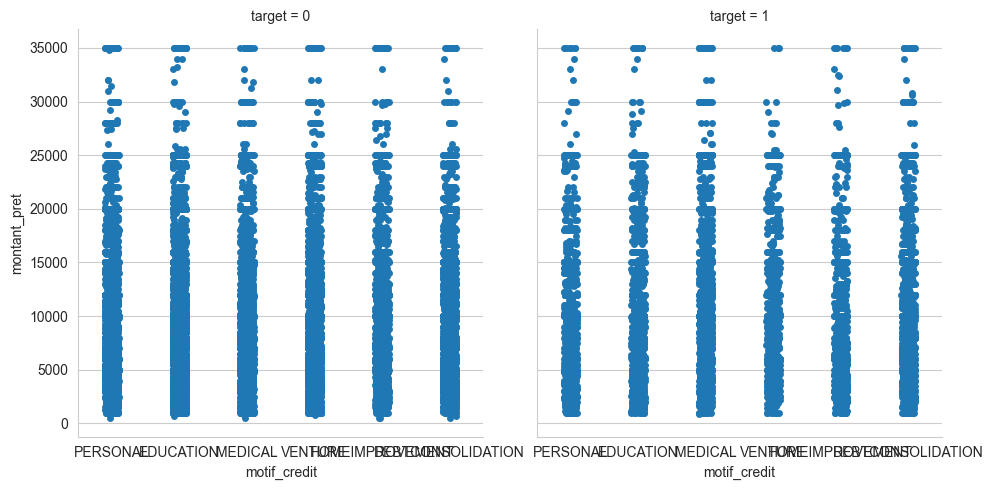

In [32]:
# motif de l'emprunt discrétiser selon la variable cible

sns.catplot(data=df, x='motif_credit' ,y = 'montant_pret', col='target')

# Nettoyage des  données

In [33]:
# Création d'une copie du DataFrame df

df_clean = df
df_clean.shape

(32581, 12)

## Outliers (Valeurs aberrantes)

Lors de l'analyse exploratoire des données, nous avons remarqué la présence de valeurs aberrantes. Ces valeurs aberrantes peuvent affecter la qualité d'un modèle de Machine Learning. Nous allons donc traiter. Avant de traiter les valeurs aberrantes, il faut d'abord les détecter.<b>
    
Il existe plusieurs méthodes de détection des outliers. Selon la méthode de la gamme interquartile Range (IQR), une valeur est aberante si :<b>
    
 * <b>   
                                                                valeur < Q1 - 1.5 * IQR<b>
    
ou
 * <b>                                                           valeur > Q3 + 1.5 * IQR<b>
    
avec
 * <b>                                                           IQR = Q3 - Q1

In [34]:
# Identification des valeurs aberrantes au niveau de la variables salaire_annuel a l'aide de la methode IQR

Q1 = df_clean['salaire_annuelle'].quantile( 0.25)
Q3 = df_clean['salaire_annuelle'].quantile( 0.75)

IQR = Q3 - Q1

print(f'1er quantile Q1 :{Q1}')
print(f'3ème quantile Q3 :{Q3}')
print(f'Inter_quantile Range IQR :{IQR}')

borne_superieur = Q3 + (1.5 * IQR)
borne_inferieur = Q1 - (1.5 * IQR)

print(f'borne_superieur : {borne_superieur}')
print(f'borne_inferieur : {borne_inferieur}')


# Suppression des valeures aberrantes au niveau de la variable salaire annuel

df = df_clean.drop(df[df['salaire_annuelle'] > borne_superieur].index, axis=0, inplace=True)


1er quantile Q1 :38500.0
3ème quantile Q3 :79200.0
Inter_quantile Range IQR :40700.0
borne_superieur : 140250.0
borne_inferieur : -22550.0


Text(0, 0.5, 'Frequency')

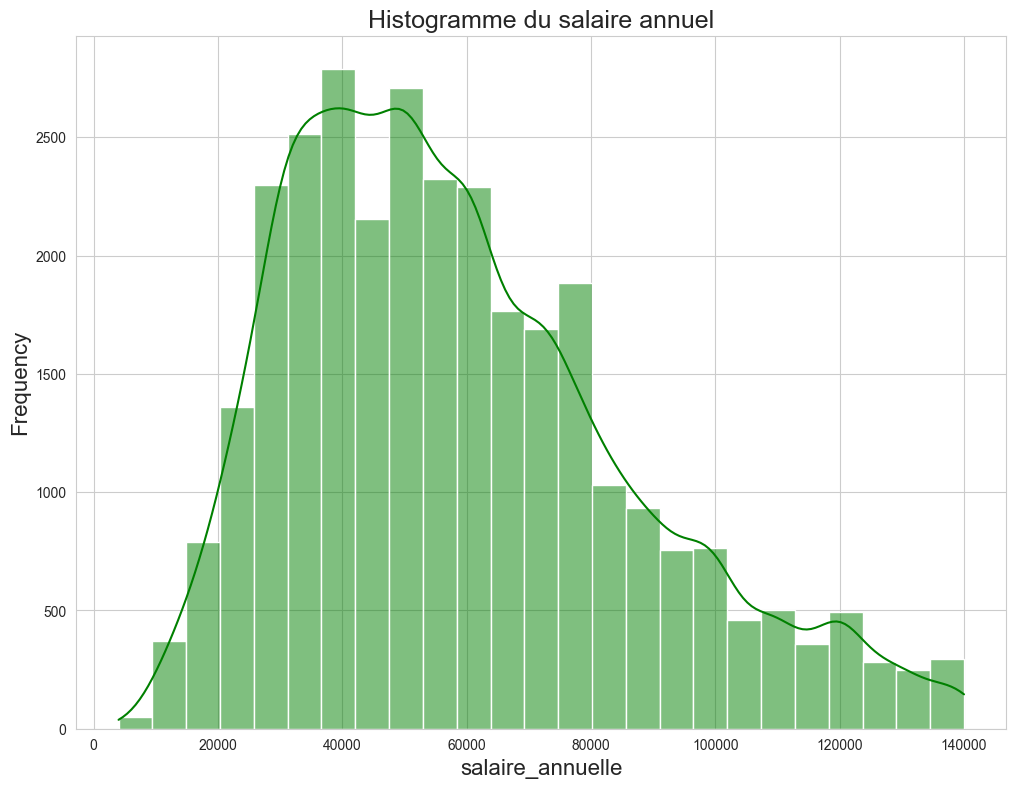

In [35]:
# Verification : Histogramme de la nouvelle variable des salaire annuel

sns.histplot(df_clean['salaire_annuelle'],kde=True, color="green", bins=25)
plt.title("Histogramme du salaire annuel", fontsize=18)
plt.xlabel('salaire_annuelle', fontsize=16)
plt.ylabel('Frequency', fontsize=16)


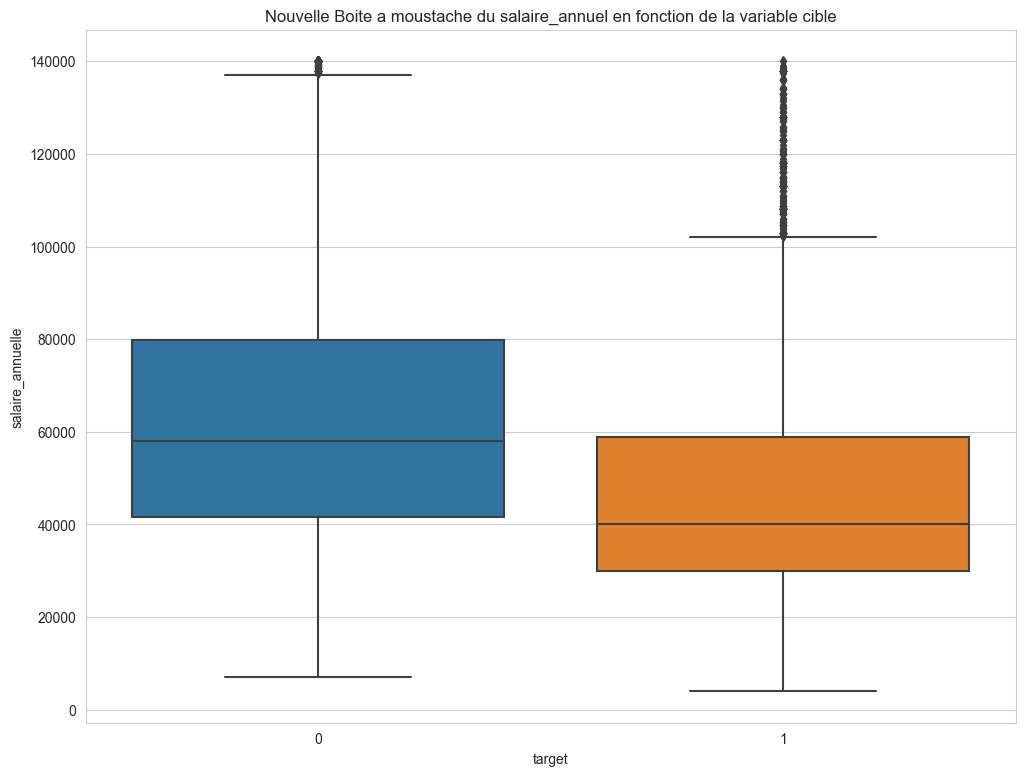

In [36]:
# Verification : Boite a moustache du salaire annuel

show_relation( df_clean, df_clean['salaire_annuelle'], 'Nouvelle Boite a moustache du salaire_annuel en fonction de la variable cible')

Après la suppression des valeurs aberantes, l'histogramme des revenus annuels a un meilleur aspect et est beaucoup plus informatif que celui construit précédemment avec les données originelles.<b>
    
Une autre manière de suppimer les valeurs aberrantes au niveau des données est de faire une simple filtration sur la base des informations recueillies lors de l'analyse exploratoire et du "bon sens".<b>
    
Il est vrai que dans certaines cas, une banque peut accorder un crédit à une personne très âgée mais ce n'est pas ce qui se fait en règle générale.

In [37]:
# Suppression des valeurs aberrantes au niveau de la variable age

df_clean = df_clean[df_clean['age'] < 100]

# Nombre de ligne finale dans df_clean

df_clean.shape

(31095, 12)

### Valeurs manquantes


Il existe deux principales techniques pour traiter les valeurs manquantes :<b>
    
* **Supression** des lignes contenant des valeurs manquantes ;<b>
* **Remplacement** des valeurs mangauntes en faisant des imputations par la moyenne, la médiane, ...etc de la variable contenant ces valeurs manquantes.<b>
Il existe également d'autres méthodes d'imputation plus ou moins sophistiquées comme la méthode des k plus proches voisins (KNN).<b>
    
Dans la pratique, il est conseillé de choisir une méthode puis de construire et d'évaluer le modèle. Puis de changer la méthode d'imputation et reconstruit le modèle ainsi de suite afin de finalement choisir une méthode qui donne les meilleurs résultats.<b>
    
Commençons par une imputation par la mediane :

In [38]:
# Voir les valeurs manquantes restantes apres suppressions des valeurs aberantes par l'IQR
df_clean.isnull().sum().sort_values(ascending=False)

taux_interet          2977
duree_emploi           881
age                      0
salaire_annuelle         0
statut                   0
motif_credit             0
class_solvabilite        0
montant_pret             0
target                   0
ratio_dette_revenu       0
credit_rembourse         0
duree_credit_ant         0
dtype: int64

In [39]:
# Extraire les valeurs manquantes de la Variable duree_emploi
index_NA_duree_emploi = df_clean['duree_emploi'].isnull().sum()
print(f'Il ya : {index_NA_duree_emploi}  valeurs manqanute dans la variable duree_emploi')


# Remplcacer les valeurs manquantes de la variable duree_emploi par sa mediane
df_clean['duree_emploi'].fillna(df_clean['duree_emploi'].median(), inplace=True)


# Verifier s'il existe encore des valeurs manquantes dans la Variable duree_emploi
print('Il reste :',df_clean['duree_emploi'].isnull().sum(),'valeurs manquantes dans la Variable duree_emploi')



Il ya : 881  valeurs manqanute dans la variable duree_emploi
Il reste : 0 valeurs manquantes dans la Variable duree_emploi


In [40]:
# Extraire les valeurs manquantes de la Variable taux_interet
index_NA_taux_interet = df_clean['taux_interet'].isnull().sum()
print(f'Il ya : {index_NA_taux_interet}  valeurs manqanute dans la variable taux_interet')


# Remplcacer les valeurs manquantes de la variable taux_interet par sa mediane
df_clean['taux_interet'].fillna(df_clean['taux_interet'].median(), inplace=True)


# Verifier s'il existe encore des valeurs manquantes dans la Variable taux_interet
print('Il reste :',df_clean['taux_interet'].isnull().sum(),'valeurs manquantes dans la Variable taux_interet')


Il ya : 2977  valeurs manqanute dans la variable taux_interet
Il reste : 0 valeurs manquantes dans la Variable taux_interet


## Préparation des donnees pour la phase modélisation

### Traitement des variables categoriels et numeriques

In [41]:
# Création d'une copie de df_clean
df_clean_2 = df_clean

In [42]:
# Scinder le dataset en données catégoriel et données numerique
cat_data=[] 
num_data=[] 

for i,c in enumerate(df_clean_2.dtypes) :     
    if c==object:
        cat_data.append(df_clean_2.iloc[:,i])
    else:
        num_data.append(df_clean_2.iloc[:,i])
        
    
# Imprimer le type des variables cat_data et num_data
print(type(cat_data))
print(type(num_data))


# Transformation des variables cat_data et num_data de type 'list' en DataFrame
cat_data = pd.DataFrame(cat_data).T  
num_data = pd.DataFrame(num_data).T  

# Imprimer les données categoriels
cat_data.head()

<class 'list'>
<class 'list'>


,statut,motif_credit,class_solvabilite,credit_rembourse
0,RENT,PERSONAL,D,Y
1,OWN,EDUCATION,B,N
2,MORTGAGE,MEDICAL,C,N
3,RENT,MEDICAL,C,N
4,RENT,MEDICAL,C,Y


In [43]:
## Transformer toute les données de Variable categoriel en 0, 1, 2...
Encoding = LabelEncoder ()
for i in cat_data:     
    cat_data[i]=Encoding.fit_transform(cat_data[i])

cat_data.head() 

,statut,motif_credit,class_solvabilite,credit_rembourse
0,3,4,3,1
1,2,1,1,0
2,0,3,2,0
3,3,3,2,0
4,3,3,2,1


In [44]:
# Extraire la variable target du  jeux de données
Target = num_data['target']
num_data.drop("target", axis=1, inplace=True)   

Target.head()

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: target, dtype: float64

In [45]:
# On concatene toute les données separer dans df_clean_2
df_clean_2 = pd.concat([num_data, cat_data], axis=1)
df_clean_2.head()

,age,salaire_annuelle,duree_emploi,montant_pret,taux_interet,ratio_dette_revenu,duree_credit_ant,statut,motif_credit,class_solvabilite,credit_rembourse
0,22.0,59000.0,123.0,35000.0,16.02,0.59,3.0,3,4,3,1
1,21.0,9600.0,5.0,1000.0,11.14,0.10,2.0,2,1,1,0
2,25.0,9600.0,1.0,5500.0,12.87,0.57,3.0,0,3,2,0
3,23.0,65500.0,4.0,35000.0,15.23,0.53,2.0,3,3,2,0
4,24.0,54400.0,8.0,35000.0,14.27,0.55,4.0,3,3,2,1


In [46]:
# Definissons le X_set et Y_set
x_stratified = df_clean_2
y_stratified = Target

X = x_stratified
Y = y_stratified

### Données d'entrainement et de test

Commençons par diviser les données en un ensemble pour entrainer les algorythmes et un ensemble de test pour évaluer la capacité du model à généraliser sur de nouvelles données (Performance du model construit). Les classe de données etant fortement desequilibrer, nous allons appliquer un stratified lors de la division, de sorte a obtenir une repartition de classe identique aussi bien dans les données d'entrainement que de test.

In [47]:
# Données d'entrainement(80%) et de test (20%)

x_train, x_test, y_train, y_test = train_test_split (X, Y, random_state=42, test_size=0.2, stratify=Y)

print("x_train taille :", x_train.shape)
print("x_test taille :", x_test.shape)
print("y_train taille :", y_train.shape)
print("y_train taille :", y_test.shape)

x_train taille : (24876, 11)
x_test taille : (6219, 11)
y_train taille : (24876,)
y_train taille : (6219,)


In [48]:
# Voyons la repartion des classe dans le y_train et comparons la à celle du y_test
y_train.value_counts()/len(y_train)

0.0    0.776089
1.0    0.223911
Name: target, dtype: float64

In [49]:
# Repartion des classe dans le y_test
y_test.value_counts()

0.0    4826
1.0    1393
Name: target, dtype: int64

In [50]:
# Repartion des classes dans le dataset d'origine
df_clean['target'].value_counts()/len(df_clean)

0    0.776073
1    0.223927
Name: target, dtype: float64

En observant les repartions dans le y_train et y_test, on constate qu'on a le meme nombre de zero "0" et de un "1", aussi bien dans le y_train que le y_test. La methode stratified a donc correctement classifier nos classe

### Normalisation des données d'entrainement

In [51]:
# Création d'une copie de x_train et y_train
x_train_norm = x_train
y_train_norm = y_train


# Normalisation en utilisant la methode MinMaxScaler
MMS       = MinMaxScaler()
mod_scaler   = MMS.fit(x_train_norm)
x_train_norm = mod_scaler.transform(x_train_norm)


# Retransformation en DataFrame
x_train_norm = pd.DataFrame(x_train_norm, columns = X.columns)

# Imprimer la table des données normalisées
x_train_norm.head()

,age,salaire_annuelle,duree_emploi,montant_pret,taux_interet,ratio_dette_revenu,duree_credit_ant,statut,motif_credit,class_solvabilite,credit_rembourse
0,0.062500,0.429399,0.065041,0.101449,0.208508,0.060976,0.071429,0.0,0.8,0.000000,0.0
1,0.140625,0.742625,0.105691,0.478261,0.289395,0.182927,0.285714,0.0,0.0,0.166667,0.0
2,0.046875,0.249993,0.056911,0.333333,0.376872,0.378049,0.000000,1.0,0.8,0.166667,0.0
3,0.156250,0.455869,0.032520,0.333333,0.125225,0.207317,0.250000,0.0,1.0,0.000000,0.0
4,0.078125,0.779389,0.073171,0.217391,0.333733,0.073171,0.035714,0.0,0.2,0.333333,0.0


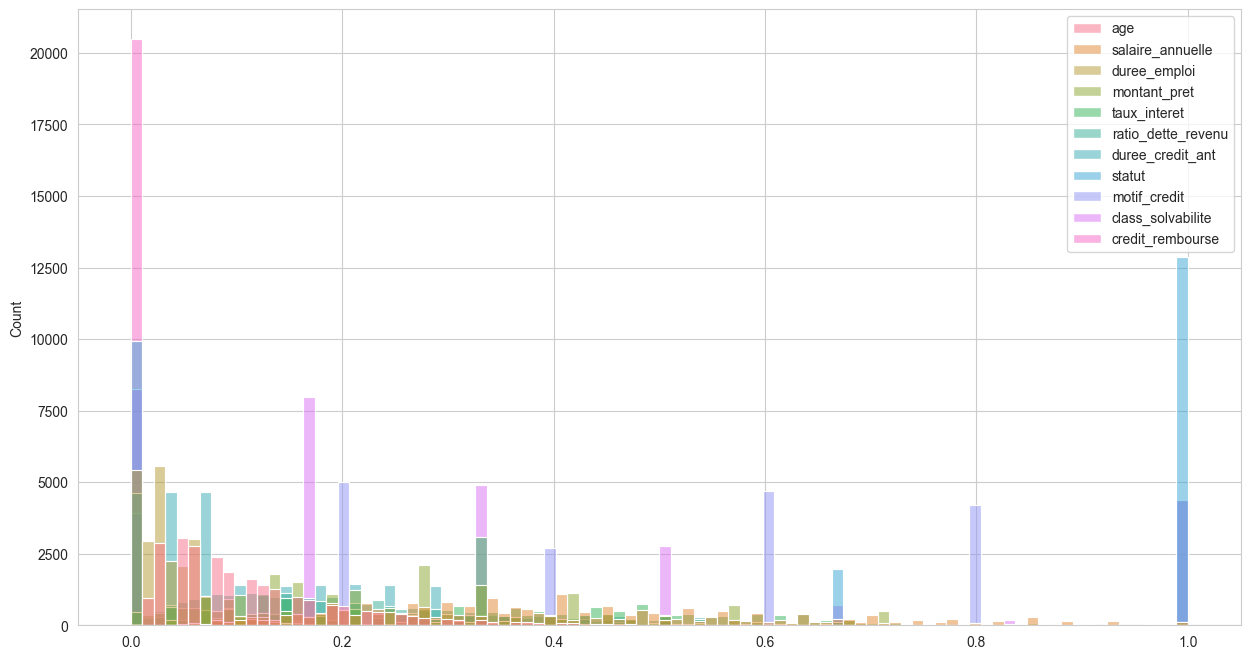

In [52]:
# Verifier l'echelle des histogrammes pour s'assurer de la normalisation
plt.rcParams["figure.figsize"] = (15, 8)
sns.histplot(x_train_norm)
sns.set_style("whitegrid")
plt.show()

En Observant ces histogrammes, on constate qu'ils sont tous dans une echelle de [0,1]. Ce qui signifie que nos données ont correctement été normaliser

### Résolution du problème de déséquilibre de classe

Il existe plusieurs techniques pour résoudre le problème de déséquilibre de classe dans les données. Le rééchantllonnage des données est rune des techniques les plus utilisées. Les méthodes de rééchantilonage souvent ulisées sont :<b>
    
* de sous-échanblionement de la classe majoritaire (**Random Under Sampling** ou RUS): cette méthode consiste à tirer au hasard des observations de cas de non-défaut pour correspondre au nombre d'observations de cas de défaut de paiement.<b>

* sur-échantilonement de la classe minoritaire (**Random Over Sampling**  Ou ROS) : cette méthode consiste à effectuer des trages aléatoires d'observations de cas de défaut et dupliquer ces observations afin de correspondre au nombre de cas de non-défaut.<b>
    
Ces deux méthodes conduisent à un équilibre parfait des cas de défaut et non-détaut de paiement mais présentent quand mème des incoménients. Avec le sous-échantillonnage, vous supprimez beaucoup d'informations. Dans la plupart des cas, jeter des données n'est pas souhaitable en apprentissage automatique. Avec le sur-échantillonnage, vous créez beaucoup de doublons d'informations ce qui peut causer des biais importants au nivedu de
l'entrainement des algorithmes.<b>
    
* Technique de sur_échantilonnnage des minorités synthétiques (**Synthetic Minority oversampling Technique** ou SMOTE en anglais) : C'est une technique sophistiquée qui ne se contente pas de juste dupliquer des cas de défaut mais utilise les caractéristiques des plus proches voisins des cas de défaut de paiement pour créer de nouveaux cas de défaut synthésques. Cette méthode bien qu'utilisant des algorithmes hyper-sophistiqués présente le risque que les voisins les plus proches des cas de détaut ne soient pas en réalité des cas de détaut, ce qui peut entrainer des erreurs de modélisation.<b>


N.B: Les méthodes de rééchantillonnages des données pour résoudre le problème de déséquilibre de classe doivent être appliquées uniquement aux données d'entrainement et NON aux données de test

In [53]:
# Nombre d'obervation de  la classe majoritaire (Non_defaut) et minoritaire (defaut)
print(sorted(Counter(y_train_norm).items()))

[(0.0, 19306), (1.0, 5570)]


### Sur_echantillonnage de la classe  minoritaire (ROS)


In [54]:
# Stockage des valeurs de la methode ROS dans la variable x_train_ros et y_train_ros
ros = RandomOverSampler(random_state = 42)
x_train_ros, y_train_ros = ros.fit_resample(x_train_norm, y_train_norm)


# Verifier si les données ont été réechantillonnées
print(sorted(Counter(y_train_ros).items()))

[(0.0, 19306), (1.0, 19306)]


### Sur_echantillonnage de la classe  minoritaire (SMOTE)

In [55]:
# Stockage des valeurs de la methode SMOTE dans la variable x_train_smote, y_train_smote
smote = SMOTE(random_state = 42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_norm, y_train_norm)

# Verifier si les données ont été réechantillonnées
print(sorted(Counter(y_train_smote).items()))


[(0.0, 19306), (1.0, 19306)]


### Sous_echantillonnage de la classe majoritaire (RUS)

In [56]:
# Stockage des valeurs de la methode RUS dans la variable x_train_rus, y_train_rus
rus = RandomUnderSampler(random_state = 42)
x_train_rus, y_train_rus = rus.fit_resample(x_train_norm, y_train_norm)

# Verifier si les données ont été réechantillonnées
print(sorted(Counter(y_train_rus).items()))


[(0.0, 5570), (1.0, 5570)]


Il est possible de créer un ensemble de données équilibrer en combinant le sur_echantillonnage de la classe minoritaitre et le sous_echantillonnage de la classe majoritaire.

# Modélisation

### Choix de la métrique d'évaluation de performance du modèle

**Quelle metrique choisir pour évaluer la performance des modèles ?**<b>

Qu'est ce qu'une matrice de confusion ?


![CONFUSION MATRICE](https://cdn-images-1.medium.com/max/565/1*3yGLac6F4mTENnj5dBNvNQ.jpeg)




La matrice de confusion est une matrice carrée qui rapporte le nombre de vrais positifs (True Positives ou TP), vrais négatifs (True Négatives ou TN), faux positifs (False Positive ou FP) et faux négatifs (False Negatives ou FN)<b>
    
Dans notre cas, la classe positive est 1: le client est en défaut de paiement et la classe négative est O : le client n'est pas en défaut de paiement.
    
* **TP** : le client est en défaut de paiement et le modèle prédit qu'il est en défaut de paiement ;<b>
* **TN** : le client n'est pas en défaut de paiement et le modèle prédit qu'il n'est pas en défaut de paiement ;<b>
    
Les 2 cas ci-dessus (TP et TN) sont les bons cas. Mais FP et FN sont les mauvais cas :<b>
    
    
* **FP** : le client n'est pas en défaut de paiement mais le modèle prédit qu'il est en défaut de paiement ;<b>
* **FN** : le client est en défaut de paiement mais le modèle prédit qu'il n'est pas en défaut de paiement.<b>
    
A partir de la matrice de confusion, nous pouvont calculer certaines métriques pour évaluer la performance du modèle.<b>
    
* La précision de la classification (Accuracy en anglais) est le pourcentage d'instances correctement classifiées, c'est-à-dire la somme du nombre de vrais négatifs et de vrais positifs divisée par le nombre total des observations. Elles se calcule donc par la formule ci-dessous :<b>
    
    **Accuracy** = $\frac{TN + TP}{TN + FN + FP+ TP}$ <b>
    
    
* **La sensibilité ou Rappel** du modèle (**Sensitivity / Recall** en anglais), repond à la question :<b>
    
 **Lorsqu'un(e) client est en défaut de paiement, combien de fois le modèle nous predit défaut ?**<b>
    
    Ils se calcule par la formule ci-dessous :<b>
    
    **Sensitivity / Recall** = $\frac{TP}{TP + FN}$ <b>
    
Dans le cas présent, la sensibilité se traduit par le pourcentage de clients en défaut de paiement (classe positive) qui ont été classifié comme tel par le modèle. Une sensibilité élevée est meilleure.<b>
    
* **La spécificité** du modèle (*Specificity* en anglais) repond à la question :<b>
    
   **Lorsqu'un(e) client n'est pas en défaut de paiement, combien de fois le modèle nous predit non_défaut ?**<b> 
    
     Ils se calcule par la formule ci-dessous :<b>
    
   **Specificity** = $\frac{TN}{TN + FP}$ <b>
    
Ici, la spécificité est le pourcentage de clients qui ne sont pas en défauts de paiement (classe négative) et qui ont été classififié comme tel par le modèle.<b>
    
* **La précision** du model (*Precision* en anglais) repond à la question :<b>
    
    **Lorsque le modèle nous predit défaut, combien de fois cette prediction est vrai ?**<b>
    
    Ils se calcule par la formule ci-dessous :<b>
    
    **Precision** = $\frac{TP}{ TP + FP}$ <b>
    
Dans notre cas, la precision est le nombre de fois que notre model ne se trompe pas en predisant defaut (classe positive).<b>
    
Une spécificité élevée est meilleure. Mais il faudra un compromis entre la sensibilité du modèle et la spécificité car l'amélioration de la sensibilité diminue la spécificité et l'amélioration de la spécificité diminue la sensibilité.<b>
    
Il faut faire attention à la précision globale. Une forte precision globale ne signifie pas que le modèle est performant. Le choix de la métrique pour qualifier la performance du modèle doit se faire en fonction du contexte de l'étude. C'est à dire, de la problematique qu'on veux resoudre.<b>
    
Dans notre cas, on essayera de minimiser le nombre de faux negatif (FN). Car en effet, on aura moins de perte à predire un  non_defaut en defaut (FP), qu'un defaut en non_defaut (FN). Notre objectif  ici, sera donc de maximiser le F-1 score /ou la sensibilité.
 

### Modèle d'arbre de decision (XGBoost)

Construction et évaluation d'un modèle d'arbre de decision en utilisant l'ensemble train_set

Avant d'entrainer le model, nous allons appliquer un stratified K-fold sur l'ensemble du dataset. Le bus est d'obtenir une meilleur performance en entrainant le modèle sur des echantillons contenant chacune des classes identiquement repartie.

### Stratified K-fold sur les données non echantillonnées

In [57]:
seed = 42

# Standard classifier
scaled = MinMaxScaler()

#GridSearchCV
param_grid = {#'Criterion': ['gini', 'entropy'], 
              'max_depth': [3,4,5,6, 7, 8, 9, 10], 
              'n_estimators': [2,3,4,5,6,7,8,9,10], 
              'learning_rate': [0.1, 0.01, 0.2, 0.3, 0.4,0.5, 0.6] }


# XGBoost Classifier
classifier = GridSearchCV(estimator=xgb.XGBClassifier(random_state = seed, n_jobs=-1),
                                param_grid= param_grid, 
                               scoring ='f1')

# StratifiedKFold classifier
skf = StratifiedKFold(n_splits= 4, shuffle=True, random_state=42)

# Metric
Metrics = pd.Series(dtype = float)

iteration = 0
for train_index, test_index in skf.split(X, Y):

  iteration += 1

  # Training_set
  x_train = x_stratified.iloc[train_index]
  y_train = y_stratified.iloc[train_index]

  # test_set
  x_test_kfold = x_stratified.iloc[test_index]
  y_test_kfold = y_stratified.iloc[test_index]

  # Standardization
  x_train_scaled = scaled.fit_transform(x_train)
  x_test_scaled  = scaled.transform(x_test_kfold)

  # Train ML classified
  classifier.fit(x_train_scaled, y_train)

  # Prediction
  y_pred = classifier.predict(x_test_scaled)


  # Sensibilité et specificité
  TN, FP, FN, TP = confusion_matrix(y_test_kfold, y_pred).ravel()
  Sensibility = TP/(TP + FN)
  Specificity = TN / (TN + FP)
  
  # Metrics
  accuracy_test  = metrics.accuracy_score(y_test_kfold, y_pred)
  precision_test = metrics.precision_score(y_test_kfold, y_pred)
  recall_test    = metrics.recall_score(y_test_kfold, y_pred)
  f1_test        = metrics.f1_score(y_test_kfold, y_pred)

  Metrics.loc[iteration] = accuracy_test
  Metrics.loc[iteration] = precision_test
  Metrics.loc[iteration] = recall_test
  Metrics.loc[iteration] = f1_test

  # Display
  print('iteration', iteration, 'accuracy  =', '{:.8f}'.format(accuracy_test))
  print('iteration', iteration, 'precision =', '{:.8f}'.format(precision_test))
  print('iteration', iteration, 'recall    =', '{:.8f}'.format(recall_test))
  print('iteration', iteration, 'f1        =', '{:.8f}'.format(f1_test))
  print('iteration', iteration,'Sensibility', Sensibility)
  print('iteration', iteration,'Specificity', Specificity)

print('Mean test accuracy', accuracy_test.mean())
print('Mean test precision', precision_test.mean())
print('Mean test recall', recall_test.mean())
print('Mean test f1', f1_test.mean())
print('Mean test Sensibility', Sensibility.mean())
print('Mean test Specificity', Specificity.mean())

# Score de classification
print(classification_report(y_test_kfold, y_pred))

# Afficher le meilleur score et le meilleur hyperparametre
print(round(classifier.best_score_, 3))
print(classifier.best_estimator_)



iteration 1 accuracy  = 0.92809365
iteration 1 precision = 0.96979332
iteration 1 recall    = 0.70074670
iteration 1 f1        = 0.81360453
iteration 1 Sensibility 0.7007466973004021
iteration 1 Specificity 0.9937013094646113
iteration 2 accuracy  = 0.93105223
iteration 2 precision = 0.97779540
iteration 2 recall    = 0.70821367
iteration 2 f1        = 0.82145237
iteration 2 Sensibility 0.7082136703044227
iteration 2 Specificity 0.9953588596055031
iteration 3 accuracy  = 0.92783638
iteration 3 precision = 0.96310832
iteration 3 recall    = 0.70476738
iteration 3 f1        = 0.81393035
iteration 3 Sensibility 0.7047673750717978
iteration 3 Specificity 0.9922095143378087
iteration 4 accuracy  = 0.93001415
iteration 4 precision = 0.96356589
iteration 4 recall    = 0.71436782
iteration 4 f1        = 0.82046205
iteration 4 Sensibility 0.714367816091954
iteration 4 Specificity 0.9922095143378087
Mean test accuracy 0.930014151550238
Mean test precision 0.9635658914728682
Mean test recall 0.71

In [80]:

# Affichage de la matrix de confusion
print('Confusion matrix:\n', metrics.confusion_matrix(y_test_kfold, y_pred),'\n','\n','Class_Value','\n', y_test.value_counts())

Confusion matrix:
 [[5986   47]
 [ 497 1243]] 
 
 Class_Value 
 0.0    4826
1.0    1393
Name: target, dtype: int64


0.8532886652148813

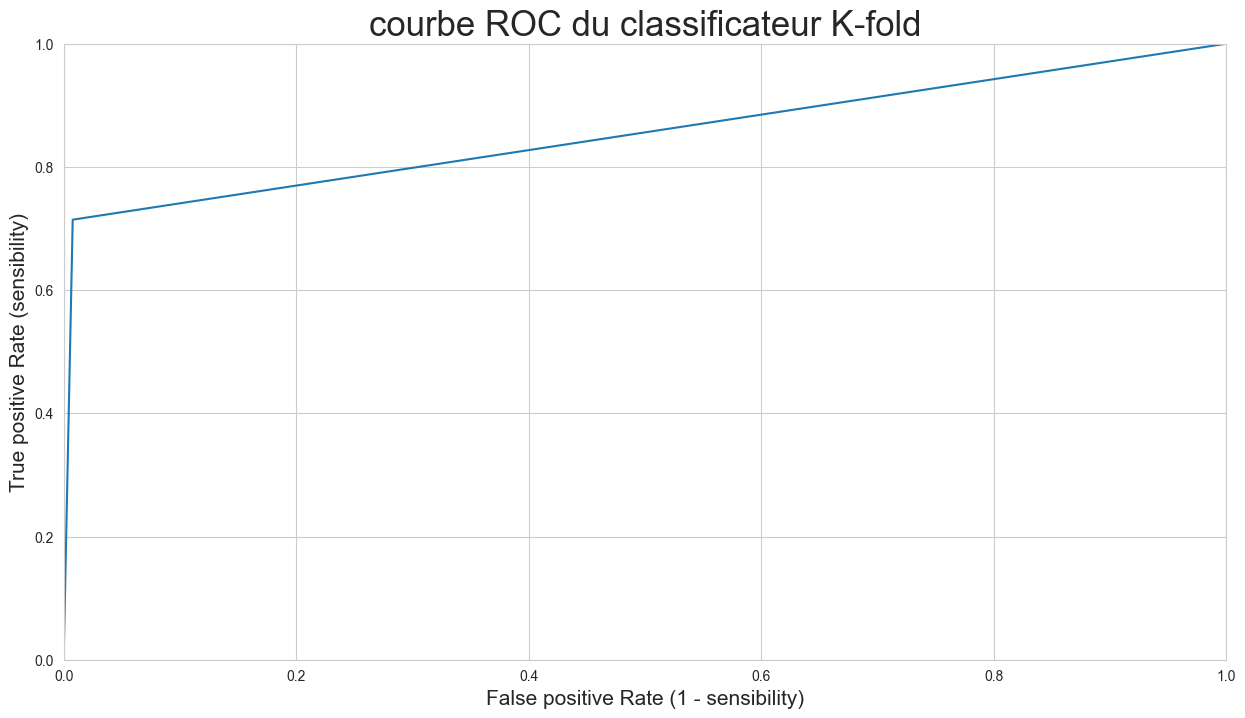

In [77]:
# Courbe ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test_kfold, y_pred )
plt.figure(figsize =(15,8))
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('courbe ROC du classificateur K-fold', size=25)
plt.xlabel('False positive Rate (1 - sensibility)', size=15)
plt.ylabel('True positive Rate (sensibility)', size=15)
plt.grid(True)

# AUC
roc_auc_score(y_test_kfold, y_pred)

### Modelisation du sous_echantillonnage a l'aide de la methode ROS

In [61]:
# Entrainement du model ROS


    #GridSearchCV de la methode ros
seed = 42 
param_grid_ros = {#'Criterion': ['gini', 'entropy'],
                  'max_depth': [3,4,5,6, 7, 8, 9, 10], 
                  'n_estimators': [2,3,4,5,6,7,8,9,10], 
                  'learning_rate': [0.1, 0.01, 0.2, 0.3, 0.4,0.5, 0.6] }

    # XGBoost Classifier
ros_classifier = GridSearchCV(estimator=xgb.XGBClassifier(random_state = seed, n_jobs=-1),
                              param_grid= param_grid_ros, 
                              scoring ='f1')
ros_classifier.fit(x_train_ros, y_train_ros)

     # Prediction
y_pred_ros = ros_classifier.predict(x_test)

     # extraction des TN, FP, FN, TP
TN, FP, FN, TP = confusion_matrix(y_test, y_pred_ros).ravel()
  
     # Definition des metrics de la methode ros
accuracy  = accuracy_score(y_test, y_pred_ros)
precision = precision_score(y_test, y_pred_ros)
recall    = recall_score(y_test, y_pred_ros)
f1        = f1_score(y_test, y_pred_ros)
Sensibility = TP /(TP + FN)
Specificity = TN / (TN + FP)

In [62]:
# Sensibilité et specificité
TN, FP, FN, TP = confusion_matrix(y_test, y_pred_ros).ravel()
Sensibility = TP/(TP + FN)
Specificity = TN / (TN + FP)
  
# Affichage des metrics de la methode ros
print('accuracy:', metrics.accuracy_score(y_test, y_pred_ros), '\n')
print('precision:', metrics.precision_score(y_test, y_pred_ros), '\n')
print('recall:', metrics.recall_score(y_test, y_pred_ros), '\n')
print('f1:', metrics.f1_score(y_test, y_pred_ros),'\n','Class_Value','\n', y_test.value_counts(), '\n')
print('Sensibility:', Sensibility, '\n')
print('Specificity:', Specificity, '\n')
print('confusion_matrix:\n',confusion_matrix(y_test, y_pred_ros),'\n', '\n','Class_Value','\n', Y.value_counts())

accuracy: 0.515516964142145 

precision: 0.28537360890302066 

recall: 0.7731514716439339 

f1: 0.4168763305593187 
 Class_Value 
 0.0    4826
1.0    1393
Name: target, dtype: int64 

Sensibility: 0.7731514716439339 

Specificity: 0.44115209283050144 

confusion_matrix:
 [[2129 2697]
 [ 316 1077]] 
 
 Class_Value 
 0.0    24132
1.0     6963
Name: target, dtype: int64


0.6071517822372178

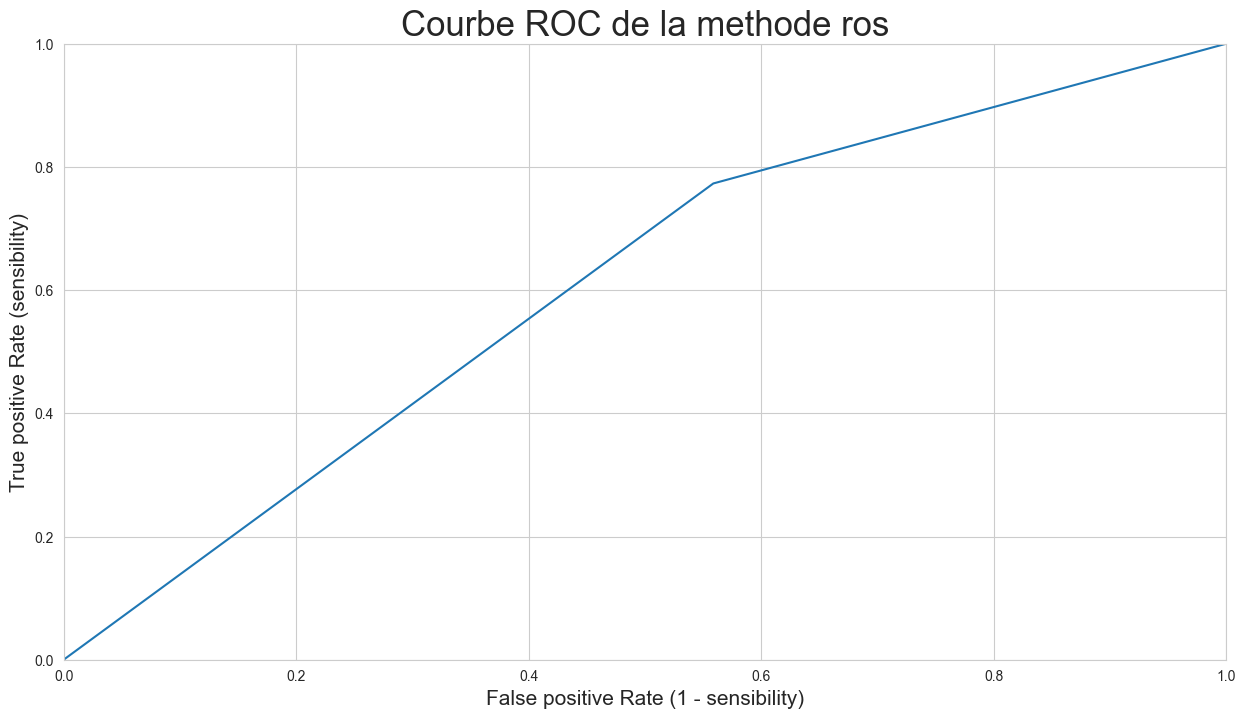

In [63]:
# Courbe ROC et AUC de la methode ros

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_ros)
plt.figure(figsize =(15,8))
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Courbe ROC de la methode ros', size=25)
plt.xlabel('False positive Rate (1 - sensibility)', size=15)
plt.ylabel('True positive Rate (sensibility)', size=15)
plt.grid(True)

  # AUC
roc_auc_score(y_test, y_pred_ros)

### Modelisation du sur_echantillonnage a l'aide de la methode SMOTE

In [64]:
# Entrainement du model smote


#GridSearchCV de la methode smote
seed = 42 
param_grid_smote = {#'Criterion': ['gini', 'entropy'],
                  'max_depth': [3,4,5,6, 7, 8, 9, 10], 
                  'n_estimators': [2,3,4,5,6,7,8,9,10], 
                  'learning_rate': [0.1, 0.01, 0.2, 0.3, 0.4,0.5, 0.6] }

    # XGBoost Classifier
smote_classifier = GridSearchCV(estimator=xgb.XGBClassifier(random_state = seed, n_jobs=-1),
                              param_grid= param_grid_smote, 
                              scoring ='f1')
smote_classifier.fit(x_train_smote, y_train_smote)

     # Prediction
y_pred_smote = smote_classifier.predict(x_test)

     # extraction des TN, FP, FN, TP
TN, FP, FN, TP = confusion_matrix(y_test, y_pred_smote).ravel()
  
     # Definition des metrics de la methode smote
accuracy  = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall    = recall_score(y_test, y_pred_smote)
f1        = f1_score(y_test, y_pred_smote)
confusion_matrix = confusion_matrix(y_test, y_pred_smote)
Sensibility = TP /(TP + FN)
Specificity = TN / (TN + FP)

    # Affichage des metrics de la methode smote
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1: ', f1,'\n','Class_Value','\n', y_test.value_counts())
print('Sensibility: ', Sensibility)
print('Specificity: ', Specificity)
print('confusion_matrix: \n', confusion_matrix,'\n','\n', 'Class_Value','\n', Y.value_counts())

accuracy:  0.49718604277214984
precision:  0.2947443181818182
recall:  0.8937544867193108
f1:  0.44329713370126406 
 Class_Value 
 0.0    4826
1.0    1393
Name: target, dtype: int64
Sensibility:  0.8937544867193108
Specificity:  0.3827186075424782
confusion_matrix: 
 [[1847 2979]
 [ 148 1245]] 
 
 Class_Value 
 0.0    24132
1.0     6963
Name: target, dtype: int64


0.6382365471308945

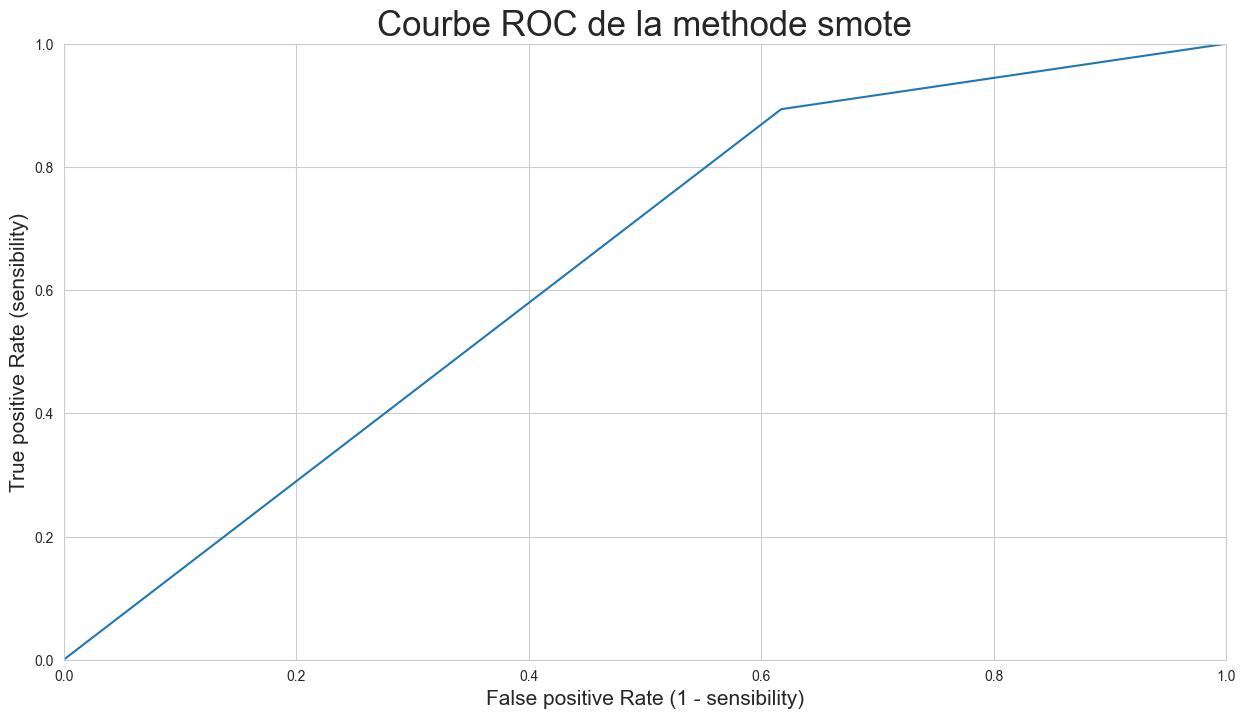

In [65]:
# Courbe ROC et AUC de la methode smote

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_smote)
plt.figure(figsize =(15,8))
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Courbe ROC de la methode smote', size=25)
plt.xlabel('False positive Rate (1 - sensibility)', size=15)
plt.ylabel('True positive Rate (sensibility)', size=15)
plt.grid(True)

  # AUC
roc_auc_score(y_test, y_pred_smote)

### Modelisation du sous_echantillonnage a l'aide de la methode RUS

In [68]:
# Entrainement du model RUS


    #GridSearchCV de la methode rus
seed = 42 
param_grid_rus = {#'Criterion': ['gini', 'entropy'],
                  'max_depth': [3,4,5,6, 7, 8, 9, 10], 
                  'n_estimators': [2,3,4,5,6,7,8,9,10], 
                  'learning_rate': [0.1, 0.01, 0.2, 0.3, 0.4,0.5, 0.6] }

    # XGBoost Classifier
rus_classifier = GridSearchCV(estimator=xgb.XGBClassifier(random_state = seed, n_jobs=-1),
                              param_grid= param_grid_rus, 
                              scoring ='f1')
rus_classifier.fit(x_train_ros, y_train_ros)

     # Prediction
y_pred_rus = rus_classifier.predict(x_test)


In [75]:
 # extraction des TN, FP, FN, TP
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred_rus).ravel()
Sensibility = TP /(TP + FN)
Specificity = TN / (TN + FP)
  
     # Definition des metrics de la methode rus
accuracy  = accuracy_score(y_test, y_pred_rus)
precision = precision_score(y_test, y_pred_rus)
recall    = recall_score(y_test, y_pred_rus)
f1        = f1_score(y_test, y_pred_rus)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rus)


    # Affichage des metrics de la methode ros
print('accuracy: ', accuracy,'\n')
print('precision: ', precision,'\n')
print('recall: ', recall,'\n')
print('f1: ', f1,'\n','Class_Value','\n', y_test.value_counts(),'\n')
print('Sensibility: ', Sensibility,'\n')
print('Specificity: ', Specificity,'\n')
print('confusion_matrix:\n', confusion_matrix,'\n','\n','Class_Value','\n', Y.value_counts())

accuracy:  0.515516964142145 

precision:  0.28537360890302066 

recall:  0.7731514716439339 

f1:  0.4168763305593187 
 Class_Value 
 0.0    4826
1.0    1393
Name: target, dtype: int64 

Sensibility:  0.7731514716439339 

Specificity:  0.44115209283050144 

confusion_matrix:
 [[2129 2697]
 [ 316 1077]] 
 
 Class_Value 
 0.0    24132
1.0     6963
Name: target, dtype: int64


0.6071517822372178

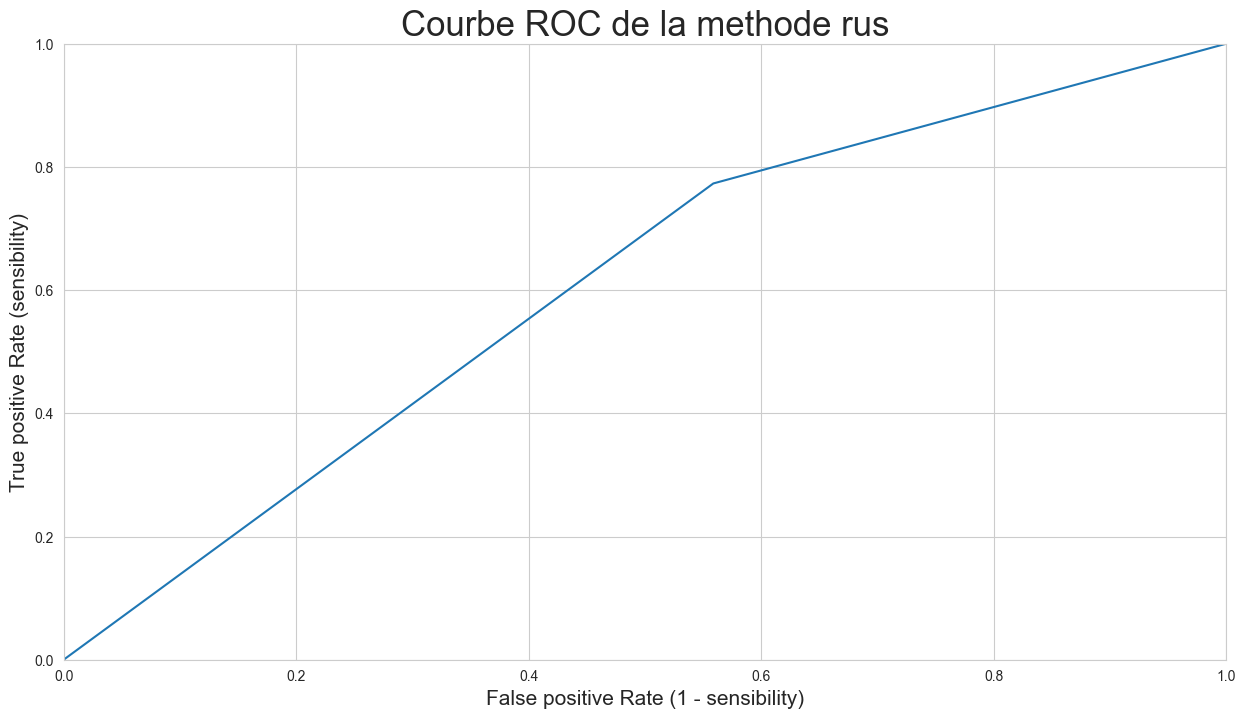

In [76]:
# Courbe ROC et AUC de la methode rus

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rus)
plt.figure(figsize =(15,8))
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Courbe ROC de la methode rus', size=25)
plt.xlabel('False positive Rate (1 - sensibility)', size=15)
plt.ylabel('True positive Rate (sensibility)', size=15)
plt.grid(True)

  # AUC
roc_auc_score(y_test, y_pred_rus)

En comparant **l'AUC, la Sensibilité et le Spécificité** des differents modeles utilisés, on remarque que le modèles le plus performant est celui qui a été construit a l'aide de la methode du Kfold. Ce modeles sera donc utiliser pour la mise en production

## Enregistrement du modeles selectionnées

In [81]:
# Enregistrement
joblib.dump(classifier, "predict_model.joblib")

['predict_model.joblib']

In [83]:
X.head()

,age,salaire_annuelle,duree_emploi,montant_pret,taux_interet,ratio_dette_revenu,duree_credit_ant,statut,motif_credit,class_solvabilite,credit_rembourse
0,22.0,59000.0,123.0,35000.0,16.02,0.59,3.0,3,4,3,1
1,21.0,9600.0,5.0,1000.0,11.14,0.10,2.0,2,1,1,0
2,25.0,9600.0,1.0,5500.0,12.87,0.57,3.0,0,3,2,0
3,23.0,65500.0,4.0,35000.0,15.23,0.53,2.0,3,3,2,0
4,24.0,54400.0,8.0,35000.0,14.27,0.55,4.0,3,3,2,1


In [85]:
X.describe()

,age,salaire_annuelle,duree_emploi,montant_pret,taux_interet,ratio_dette_revenu,duree_credit_ant,statut,motif_credit,class_solvabilite,credit_rembourse
count,31095.000000,31095.000000,31095.000000,31095.000000,31095.000000,31095.000000,31095.000000,31095.000000,31095.000000,31095.000000,31095.000000
mean,27.592764,58703.694099,4.688085,9289.015115,10.995480,0.174322,5.726612,1.715324,2.533462,1.213764,0.175945
std,6.149496,27519.459720,3.960755,6038.231202,3.077697,0.107049,4.007153,1.427748,1.729923,1.163267,0.380779
min,20.000000,4000.000000,0.000000,500.000000,5.420000,0.010000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,38000.000000,2.000000,5000.000000,8.490000,0.090000,3.000000,0.000000,1.000000,0.000000,0.000000
50%,26.000000,54000.000000,4.000000,8000.000000,10.990000,0.150000,4.000000,3.000000,3.000000,1.000000,0.000000
75%,30.000000,75000.000000,7.000000,12000.000000,13.110000,0.230000,8.000000,3.000000,4.000000,2.000000,0.000000
max,94.000000,140004.000000,123.000000,35000.000000,23.220000,0.830000,30.000000,3.000000,5.000000,6.000000,1.000000


In [ ]:
"""df.rename(columns={'person_age': 'age', 
                   'person_income':'salaire_annuelle',
                   'person_home_ownership':'statut',
                   'person_emp_length':'duree_emploi',
                   'loan_intent': 'motif_credit',
                   'loan_grade':'class_solvabilite',
                   'loan_amnt':'montant_pret',
                  'loan_int_rate':'taux_interet',
                  'loan_status':'target',
                  'loan_percent_income':'ratio_dette_revenu',
                  'cb_person_default_on_file':'credit_rembourse',
                  'cb_person_cred_hist_length':'duree_credit_ant'},inplace=True)
"""
# y_test.value_counts()